### prelims

In [1]:
#| default_exp kneefit

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
from pathlib import Path

import submitit
import torch
from diffdrr.drr import DRR
from diffdrr.metrics import MultiscaleNormalizedCrossCorrelation2d
from pytorch_transformers.optimization import WarmupCosineSchedule
from timm.utils.agc import adaptive_clip_grad as adaptive_clip_grad_
from tqdm import tqdm
import ipdb
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T

import tifffile as tiff



In [4]:
#| export
from pathlib import Path
from typing import Optional, Union

import h5py
import numpy as np
import torch
from beartype import beartype
import nibabel as nib
import pandas as pd
import tifffile as tiff
import matplotlib as plt

import os
import sys

# Function to find the root directory of the project
def find_project_root(current_path, marker_file):
    while current_path != os.path.dirname(current_path):
        if marker_file in os.listdir(current_path):
            return current_path
        current_path = os.path.dirname(current_path)
    return None

# Get the current working directory
cwd = os.getcwd()

marker_file = '.git'

# Find the root directory
project_root = find_project_root(cwd, marker_file)

sys.path.append(project_root)

from diffpose.calibration import RigidTransform, perspective_projection, convert
from diffpose.kneefit import Transforms, get_random_offset
from diffpose.metrics import DoubleGeodesic, GeodesicSE3
from diffpose.registration import PoseRegressor

# `DeepFluoro`

In [97]:
#| export
@beartype
class KneeFitDataset(torch.utils.data.Dataset):
    """
    Get X-ray projections and poses from specimens in the `DeepFluoro` dataset.

    Given a specimen ID and projection index, returns the projection and the camera matrix for DiffDRR.
    """

    def __init__(
        self,
        id_number: int,  # Specimen number (1-6)
        filename: Optional[Union[str, Path]] = None,  # Path to DeepFluoro h5 file
        preprocess: bool = True,  # Preprocess X-rays,
        volume_type: str = "femur"
    ):
        # Load the volume
        (
            self.projections,
            self.volume,
            self.spacing,
            self.lps2volume,
            self.intrinsic,
            self.extrinsic,
            self.focal_len,
            self.x0,
            self.y0,
            self.delx
        ) = load_kneefit_dataset(id_number, filename, volume_type)
        self.preprocess = preprocess
        self.volume_type = volume_type

        # Get the isocenter pose (AP viewing angle at volume isocenter)
        # probably have to change the viewing angle here to LAT viewing angle

        print(f"isocenter_xyz = {torch.tensor(self.volume.shape)} * {self.spacing} / 2")
      

        ############## ISOCENTER XYZ FROM SYNTHETIC NET ###########
        # for left leg
        # isocenter_rot = torch.tensor([[-torch.pi / 2, 0, 0]])
        # isocenter_xyz = torch.tensor(self.volume.shape) * self.spacing / 2
        # isocenter_xyz = isocenter_xyz.unsqueeze(0)
        # shift = torch.tensor([[+972/2, 0, 0]], dtype=torch.float32)

        # for right leg
        isocenter_rot = torch.tensor([[-torch.pi / 2, -torch.pi, 0]])
        isocenter_xyz = torch.tensor(self.volume.shape) * self.spacing / 2
        print("ISO XYZ = ", isocenter_xyz)

        isocenter_xyz = isocenter_xyz.unsqueeze(0)
        shift = torch.tensor([[0, 0, -30]], dtype=torch.float32)
        # shift = torch.tensor([[0, 0, 0]], dtype=torch.float32)


        # isocenter_xyz += shift

        print("ISO XYZ = ", isocenter_xyz)




        isocenter_xyz = isocenter_xyz.unsqueeze(0)
        self.isocenter_pose = RigidTransform(
            isocenter_rot, isocenter_xyz, "euler_angles", "XYZ"
        )

        # Camera matrices and fiducials for the specimen
        # self.fiducials = get_3d_fiducials(self.specimen)
        # self.fiducials = get_3d_fiducials(self.volume)

        # Miscellaneous transformation matrices for wrangling SE(3) poses
        self.flip_xz = RigidTransform(
            torch.tensor([[0.0, 0.0, -1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]),
            torch.zeros(3),
        )
        self.translate = RigidTransform(
            torch.eye(3),
            torch.tensor([-self.focal_len/2, 0, 0]),
            # torch.tensor([0, 0, -self.focal_len / 2]),
        )
        self.flip_180 = RigidTransform(
            torch.tensor([[1.0, 0.0, 0.0], [0.0, -1.0, 0.0], [0.0, 0.0, -1.0]]),
            torch.zeros(3),
        )
        ## z 90
        # self.rot_z = RigidTransform(torch.tensor([[0 , 1.0, 0], [-1, 0, 0], [0, 0, 1]]), torch.ones(3))
        ## z 180
        # self.rot_z = RigidTransform(torch.tensor([[-1.0 , -0.0, 0], [0.0, -1.0, 0], [0, 0, 1]]), torch.ones(3))
        ## x 90
        if self.volume_type == "femur":
            self.rot_z = RigidTransform(torch.tensor([0, 0, -torch.pi/4]), torch.zeros(3), "euler_angles", "XYZ")
            self.rot_z_ = RigidTransform(torch.tensor([torch.pi/4, 0.0, 0 ]), torch.zeros(3), "euler_angles", "XYZ")
            self.rot_x = RigidTransform(torch.tensor([[1.0 , 0, 0], [0, -1, 0], [0, 0, -1]]), torch.zeros(3))


        else:
            self.rot_z = RigidTransform(torch.tensor([0, 0, 0.0]), torch.zeros(3), "euler_angles", "XYZ")
            self.rot_x = RigidTransform(torch.tensor([[1.0 , 0, 0], [0, -1, 0], [0, 0, -1]]), torch.zeros(3))

        # self.rot_z = RigidTransform(torch.tensor([0, 0, torch.pi/2]), torch.zeros(3), "euler_angles", "XYZ")

        ## y -90
        # self.rot_z = RigidTransform(torch.tensor([[-1.0 , 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0, -1.0]]), torch.ones(3))





    def __len__(self):
        return len(self.projections)

    def __iter__(self):
        return iter(self[idx] for idx in range(len(self)))

    def __getitem__(self, idx):
        """
        (1) Swap the x- and z-axes
        (2) Reverse the x-axis to make the matrix E(3) -> SE(3)
        (3) Move the camera to the origin
        (4) Rotate the detector plane by 180, if offset
        (5) Form the full SE(3) transformation matrix
        """
        print("get item called")
        projection = self.projections.iloc[idx]
        img = self.process_image(projection["img_path"])
        world2volume = self.get_gt_pose(projection)
        # world2volume[:3, 3] = torch.tensor([120,90,250],dtype=torch.float32)
        world2volume = RigidTransform(world2volume[:3, :3], world2volume[:3, 3])
        pose = convert_deepfluoro_to_diffdrr(self, world2volume)
        # print(pose)

        # Handle rotations in the imaging dataset
        # if self._rot_180_for_up(idx):
        #     img = torch.rot90(img, k=2)
        #     pose = self.flip_180.compose(pose)

        # Optionally, preprocess the images
        img = img.unsqueeze(0).unsqueeze(0)
        if self.preprocess:
            img = preprocess(img)

        img_raw = tiff.imread(projection["img_path"])

        return img, pose, img_raw
    
    def get_gt_pose(self, projection):
        # # print(projection)
        ## tibia local machine
        # gt_pose = torch.tensor([[projection[f"{self.volume_type}_rxx"], projection[f"{self.volume_type}_rxy"], projection[f"{self.volume_type}_rxz"], -116.402],
        #                         [projection[f"{self.volume_type}_ryx"], projection[f"{self.volume_type}_ryy"], projection[f"{self.volume_type}_ryz"], -196.095],
        #                         [projection[f"{self.volume_type}_rzx"], projection[f"{self.volume_type}_rzy"], projection[f"{self.volume_type}_rzz"], -947.326],
        #                         [0, 0, 0, 1]], dtype=torch.float32)
        

        ## femur sub2 - 0
        # gt_pose = torch.tensor([[projection[f"{self.volume_type}_rxx"], projection[f"{self.volume_type}_rxy"], projection[f"{self.volume_type}_rxz"], -119.553],
        #                         [projection[f"{self.volume_type}_ryx"], projection[f"{self.volume_type}_ryy"], projection[f"{self.volume_type}_ryz"], -116.432],
        #                         [projection[f"{self.volume_type}_rzx"], projection[f"{self.volume_type}_rzy"], projection[f"{self.volume_type}_rzz"], -987.334],
        #                         [0, 0, 0, 1]], dtype=torch.float32)
        
        ## femur sub2 - 21
        # gt_pose = torch.tensor([[projection[f"{self.volume_type}_rxx"], projection[f"{self.volume_type}_rxy"], projection[f"{self.volume_type}_rxz"], -217.279],
        #                         [projection[f"{self.volume_type}_ryx"], projection[f"{self.volume_type}_ryy"], projection[f"{self.volume_type}_ryz"], -34.6134],
        #                         [projection[f"{self.volume_type}_rzx"], projection[f"{self.volume_type}_rzy"], projection[f"{self.volume_type}_rzz"], -973.889],
        #                         [0, 0, 0, 1]], dtype=torch.float32)
        
        gt_pose = torch.tensor([[projection[f"{self.volume_type}_rxx"], projection[f"{self.volume_type}_rxy"], projection[f"{self.volume_type}_rxz"], projection[f"{self.volume_type}_tx"]],
                        [projection[f"{self.volume_type}_ryx"], projection[f"{self.volume_type}_ryy"], projection[f"{self.volume_type}_ryz"], projection[f"{self.volume_type}_ty"]],
                        [projection[f"{self.volume_type}_rzx"], projection[f"{self.volume_type}_rzy"], projection[f"{self.volume_type}_rzz"], projection[f"{self.volume_type}_tz"]],
                        [0, 0, 0, 1]], dtype=torch.float32)
        return gt_pose
    
    def process_image(self, img_path):
        xray_img = tiff.imread(img_path)

        print(type(xray_img))
        print(xray_img.shape)
        xray_tensor = torch.tensor(xray_img, dtype=torch.float32, device='cuda')
        plt.imshow(xray_tensor.cpu().numpy())
        xray_tensor = xray_tensor.unsqueeze(0).unsqueeze(0)

        print(xray_tensor.shape)
        return xray_tensor

    def get_2d_fiducials(self, idx, pose):
        # Get the fiducials from the true camera pose
        _, true_pose = self.__getitem__(idx)
        extrinsic = (
            self.lps2volume.inverse()
            .compose(true_pose.inverse())
            .compose(self.translate)
            .compose(self.flip_xz)
        )
        true_fiducials = perspective_projection(
            extrinsic, self.intrinsic, self.fiducials
        )

        # Get the fiducials from the predicted camera pose
        extrinsic = (
            self.lps2volume.inverse()
            .compose(pose.cpu().inverse())
            .compose(self.translate)
            .compose(self.flip_xz)
        )
        pred_fiducials = perspective_projection(
            extrinsic, self.intrinsic, self.fiducials
        )

        if self.preprocess:
            true_fiducials -= 50
            pred_fiducials -= 50

        return true_fiducials, pred_fiducials

    # def _rot_180_for_up(self, idx):

    
    
    #     return self.projections[f"{idx:03d}"]["rot-180-for-up"][()]

gt with zyx convention 
[103.16925712 -14.14377023 -88.36142518]

gt_inv with xyz convention
[  88.36142523   14.14377022 -103.16925706]


op rot after flip xz
[[-104.1493,   -1.5889,   12.7688]]

rotation tensor([[  -1.6337,   12.7632, -104.5098]], device='cuda:0')


gt with zyx convention 
[103.16925712 -14.14377023 -88.36142518]

gt_inv with xyz convention
[  88.36142523   14.14377022 -103.16925706]


op rot after flip xz
[[-104.1493,   -1.5889,   12.7688]]

rotation tensor([[  -1.6337,   12.7632, -104.5098]], device='cuda:0')


In [98]:
#| export
def convert_deepfluoro_to_diffdrr(specimen, pose: RigidTransform):
    """Transform the camera coordinate system used in DeepFluoro to the convention used by DiffDRR."""
    print(specimen)
    # pose = pose.compose(specimen.rot_z)
    # pose = specimen.lps2volume.inverse().compose(specimen.rot_z).compose(specimen.lps2volume).compose(pose)
    # pose = specimen.lps2volume.compose(specimen.rot_z).compose(specimen.lps2volume.inverse()).compose(pose)


    # pose = specimen.lps2volume.compose(specimen.rot_z).compose(specimen.lps2volume.inverse()).compose(specimen.lps2volume.inverse()).compose(specimen.rot_z_).compose(specimen.lps2volume).compose(pose)
    # pose = specimen.lps2volume.inverse().compose(specimen.rot_z_).compose(specimen.rot_z).compose(specimen.lps2volume).compose(pose)

    # # pose = specimen.lps2volume.inverse().compose(specimen.rot_z_).compose(specimen.lps2volume).compose(specimen.lps2volume).compose(specimen.rot_z).compose(specimen.lps2volume.inverse()).compose(pose)

    # print('GROUND TRUTH POSE', pose.get_rotation("euler_angles", "XYZ"))
    # print(pose.get_translation())
    # pose_inv = pose.inverse()
    # print('INVERSE GROUND TRUTH POSE', pose_inv.get_rotation("euler_angles", "XYZ"))
    # print(pose_inv.get_translation())
    # print('lps 2 volume', specimen.lps2volume.inverse().get_rotation(), specimen.lps2volume.inverse().get_translation())
    # print('pose', pose.get_rotation(), pose.get_translation())
    # print('extrinsic inverse', specimen.extrinsic.inverse().get_rotation(), specimen.extrinsic.inverse().get_translation())
    # print('translation', specimen.translate.get_rotation(), specimen.translate.get_translation())
    
    # ## deep fluoro without extrinsics
    # return (
    #     # specimen.rot_z
    #     specimen.translate
    #     # .compose(specimen.rot_z)
    #     # specimen.flip_xz
    #     .compose(specimen.extrinsic.inverse())
    #     .compose(specimen.flip_xz)
        
    #     # .compose(specimen.lps2volume)
    #     .compose(pose_inv)
    #     # .compose(specimen.lps2volume.inverse())
    #     )
    pose = specimen.lps2volume.inverse().compose(specimen.rot_z).compose(specimen.lps2volume).compose(pose)
    pose_inv = pose.inverse()
    return (
        specimen.rot_x
        # specimen.translate
        .compose(specimen.translate)

        .compose(specimen.extrinsic.inverse())
        .compose(specimen.flip_xz)
        .compose(pose_inv)
        )
    # return (
    #         # specimen.translate
    #         # specimen.flip_xz
    #         specimen.extrinsic.inverse()
    #         .compose(pose)
    #         .compose(specimen.lps2volume.inverse())

    #         .compose(specimen.flip_xz)
    #         # .compose(specimen.translate)

    #     )

    # return (
    #     # specimen.lps2volume.inverse().compose(pose).compose(specimen.flip_xz).compose(specimen.translate)
    #     pose
    #     # specimen.lps2volume.inverse()
    #     # .compose(pose)
    #     # .compose(specimen.extrinsic)
    #     .compose(specimen.flip_xz)
    #     .compose(specimen.translate)
    #     # pose.compose(specimen.flip_xz).compose(specimen.translate)

    # )

    # THIS IS WORKING
    # return (
    #     # specimen.lps2volume.inverse().compose(pose).compose(specimen.flip_xz).compose(specimen.translate)
    #     specimen.lps2volume.inverse()
    #     .compose(pose)
    #     .compose(specimen.extrinsic.inverse())
    #     .compose(specimen.flip_xz)
    #     .compose(specimen.translate)
    #     # pose.compose(specimen.flip_xz).compose(specimen.translate)

    # )

def convert_diffdrr_to_deepfluoro(specimen, pose: RigidTransform):
    """Transform the camera coordinate system used in DiffDRR to the convention used by DeepFluoro."""
    return (
        # specimen.lps2volume.inverse()
        specimen.compose(pose.inverse())
        .compose(specimen.translate)
        .compose(specimen.flip_xz)
    )

In [99]:
#| export
from torch.nn.functional import pad

from diffpose.calibration import perspective_projection


class Evaluator:
    def __init__(self, specimen, idx):
        # Save matrices to device
        self.translate = specimen.translate
        self.specimen.flip_xz
        self.intrinsic = specimen.intrinsic
        self.intrinsic_inv = specimen.intrinsic.inverse()

        # Get gt fiducial locations
        self.specimen = specimen
        self.fiducials = specimen.fiducials
        gt_pose = specimen[idx][1]
        self.true_projected_fiducials = self.project(gt_pose)

    def project(self, pose):
        extrinsic = convert_diffdrr_to_deepfluoro(self.specimen, pose)
        x = perspective_projection(extrinsic, self.intrinsic, self.fiducials)
        x = -self.specimen.focal_len * torch.einsum(
            "ij, bnj -> bni",
            self.intrinsic_inv,
            pad(x, (0, 1), value=1),  # Convert to homogenous coordinates
        )
        extrinsic = (
            self.flip_xz.inverse().compose(self.translate.inverse()).compose(pose)
        )
        return extrinsic.transform_points(x)

    def __call__(self, pose):
        pred_projected_fiducials = self.project(pose)
        registration_error = (
            (self.true_projected_fiducials - pred_projected_fiducials)
            .norm(dim=-1)
            .mean()
        )
        registration_error *= 0.194  # Pixel spacing is 0.194 mm / pixel isotropic
        return registration_error

In [100]:
#| export
from diffdrr.utils import parse_intrinsic_matrix, get_principal_point


def load_kneefit_dataset(id_number, filename, volume_type):
    # Open the H5 file for the dataset
    if filename is None:
        # root = Path(__file__).parent.parent.absolute()
        # filename = Path.cwd().parent.parent.absolute() / "data/sipla_bone_preprocessed.csv"
        filename = Path.cwd().parent.parent.absolute() / "data/sipla_bone_local_preprocessed.csv"
    f = pd.read_csv(filename)
    assert id_number in range(1, f["patient_id"].nunique())
    f = f[f["patient_id"] == id_number]
    (
        intrinsic,
        extrinsic,
        num_cols,
        num_rows,
        proj_col_spacing,
        proj_row_spacing,
    ) = parse_proj_params(f)

    # uncomment if focal length is in unit length
    focal_len = intrinsic[0,0]
    x0, y0 = intrinsic[0,2], intrinsic[1,2]

    # uncomment if focal length is in pixels
    # focal_len, x0, y0 = parse_intrinsic_matrix(
    #     intrinsic,
    #     num_rows,
    #     num_cols,
    #     proj_row_spacing,
    #     proj_col_spacing,
    # )


    # Try to load the particular specimen
    projections = f[f["patient_id"] == id_number]

    # Parse the volume
    volume, spacing, lps2volume = parse_volume(projections, volume_type)
    return (
        projections,
        volume,
        spacing,
        lps2volume,
        intrinsic,
        extrinsic,
        focal_len,
        x0,
        y0,
        proj_row_spacing
    )

def get_volume_data(volume):
    nii_data = nib.load(volume)
    # Access the affine transformation matrix
    # affine = nii_data.affine
    # Access the image data as a NumPy array
    data = nii_data.get_fdata()
    # Access the affine transformation matrix
    affine = nii_data.affine
    return data, affine


def parse_volume(specimen, volume_type):
    # Parse the volume
    #use pitch as spacing if using stl converted to voxel grid OR use code from nii library nibabel from data_analysis notebook
    # spacing = specimen["vol/spacing"][:].flatten()
    print(specimen["spacing"].unique()[0])
    spacing = np.array(eval(specimen["spacing"].unique()[0])).astype(np.float32)
    #check shape of 3d array
    # import ipdb; ipdb.set_trace()
    volume, affine = get_volume_data(specimen[f"{volume_type}_nii"].unique()[0])
    print("affine transformation matrix", affine)

    volume = volume.astype(np.float32)
    # volume = specimen["vol/pixels"][:].astype(np.float32)

    #is swapping the axis same as changing lateral to AP view?
    # volume = np.swapaxes(volume, 0, 2)[::-1].copy()

    # Parse the translation matrix from LPS coordinates to volume coordinates
    origin = torch.tensor(affine[:3, 3])
    # origin = torch.tensor(affine[:3, 3] * [0.8, 0.39, 0.39])

    # try - 175, 100, 100
    # try 175, 100, 100
    # origin = torch.tensor([101.69,  -34.1625, -197.777], dtype=torch.float32)
    # origin = torch.tensor([175, 100, 100], dtype=torch.float32)

    lps2volume = RigidTransform(torch.eye(3), origin)
    return volume, spacing, lps2volume


def parse_proj_params(f):
    # proj_params = f["proj-params"]
    # extrinsic parameters here do not matter, set to zeros
    try:
        fx = f["cal_focal_length"].unique()[0]
        px = f["cal_principalp_x"].unique()[0]
        py = f["cal_principalp_y"].unique()[0]
    except Exception as err:
        print("camera instrinsics must be the same for all frames of 1 patient")
        sys.exit()
    extrinsic = torch.eye(4, dtype=torch.float32)
    extrinsic[0, 3] = px
    extrinsic[1, 3] = py
    # extrinsic[2, 3] = fx

    

    # understand why extrinsic goes through RigidTransform
    extrinsic = RigidTransform(extrinsic[..., :3, :3], extrinsic[:3, 3])
    intrinsic = torch.tensor([[fx, 0, px],
                              [0, fx, py],
                              [0, 0, 1]], dtype=torch.float32)
    num_cols = num_rows = 1000
    proj_col_spacing = proj_row_spacing = float(f["cal_mm_per_pxl"].unique()[0])
    return intrinsic, extrinsic, num_cols, num_rows, proj_col_spacing, proj_row_spacing

def get_3d_fiducials(specimen):
    fiducials = []
    for landmark in specimen["vol-landmarks"]:
        pt_3d = specimen["vol-landmarks"][landmark][:]
        pt_3d = torch.from_numpy(pt_3d)
        fiducials.append(pt_3d)
    return torch.stack(fiducials, dim=0).permute(2, 0, 1)

In [101]:
#| export
from torchvision.transforms.functional import center_crop, gaussian_blur


def preprocess(img, size=None, initial_energy=torch.tensor(65487.0)):
    """
    Recover the line integral: $L[i,j] = \log I_0 - \log I_f[i,j]$

    (1) Remove edge due to collimator
    (2) Smooth the image to make less noisy
    (3) Subtract the log initial energy for each ray
    (4) Recover the line integral image
    (5) Rescale image to [0, 1]
    """
    img = center_crop(img, (1436, 1436))
    img = gaussian_blur(img, (5, 5), sigma=1.0)
    img = initial_energy.log() - img.log()
    img = (img - img.min()) / (img.max() - img.min())
    return img

## Basic functionalities

`DeepFluoroDataset` is a `torch.utils.data.Dataset` that stores imaging data (`volume`, `spacing`, and `focal_len`) and provides an API for getting X-ray images and associated camera poses. The imaging data can be passed to a `diffdrr.drr.DRR` to render DRRs from a specific patient.

In [102]:
#| eval: false
import matplotlib.pyplot as plt
from diffdrr.drr import DRR
from tqdm import tqdm

# DRR for knee pose

### necessary stuff

In [103]:
def train(
    id_number,
    model,
    optimizer,
    scheduler,
    drr,
    transforms,
    isocenter_pose,
    device,
    batch_size,
    n_epochs,
    n_batches_per_epoch,
    model_params,
):
    metric = MultiscaleNormalizedCrossCorrelation2d(eps=1e-4)
    geodesic = GeodesicSE3()
    double = DoubleGeodesic(drr.detector.sdr)
    contrast_distribution = torch.distributions.Uniform(1.0, 10.0)

    best_loss = torch.inf

    model.train()
    #  visualization part
    offset = get_random_offset(batch_size, device)
    pose = isocenter_pose.compose(offset)

    # visualize(drr=drr, pose=pose,device=device)
    for epoch in range(n_epochs + 1):
        losses = []
        for _ in (itr := tqdm(range(n_batches_per_epoch), leave=False)):
            # bone_attenuation is chosen randomly from a uniform distribution
            contrast = contrast_distribution.sample().item()
            # generate random pose using normal distribution
            offset = get_random_offset(batch_size, device)
            pose = isocenter_pose.compose(offset)
            img = drr(None, None, None, pose=pose, bone_attenuation_multiplier=contrast)
            img = transforms(img)
            
            img = img.float()

            pred_offset = model(img)
            pred_pose = isocenter_pose.compose(pred_offset)
            pred_img = drr(None, None, None, pose=pred_pose)
            pred_img = transforms(pred_img)
            pred_img = pred_img.float()

            ncc = metric(pred_img, img)
            log_geodesic = geodesic(pred_pose, pose)
            geodesic_rot, geodesic_xyz, double_geodesic = double(pred_pose, pose)
            loss = 1 - ncc + 1e-2 * (log_geodesic + double_geodesic)
            if loss.isnan().any():
                print("Aaaaaaand we've crashed...")
                print(ncc)
                print(log_geodesic)
                print(geodesic_rot)
                print(geodesic_xyz)
                print(double_geodesic)
                print(pose.get_matrix())
                print(pred_pose.get_matrix())
                torch.save(
                    {
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "height": drr.detector.height,
                        "epoch": epoch,
                        "batch_size": batch_size,
                        "n_epochs": n_epochs,
                        "n_batches_per_epoch": n_batches_per_epoch,
                        "pose": pose.get_matrix().cpu(),
                        "pred_pose": pred_pose.get_matrix().cpu(),
                        "img": img.cpu(),
                        "pred_img": pred_img.cpu()
                        **model_params,
                    },
                    f"checkpoints/specimen_{id_number:02d}_crashed.ckpt",
                )
                raise RuntimeError("NaN loss")

            optimizer.zero_grad()
            loss.mean().backward()
            adaptive_clip_grad_(model.parameters())
            optimizer.step()
            scheduler.step()

            losses.append(loss.mean().item())

            # Update progress bar
            itr.set_description(f"Epoch [{epoch}/{n_epochs}]")
            itr.set_postfix(
                geodesic_rot=geodesic_rot.mean().item(),
                geodesic_xyz=geodesic_xyz.mean().item(),
                geodesic_dou=double_geodesic.mean().item(),
                geodesic_se3=log_geodesic.mean().item(),
                loss=loss.mean().item(),
                ncc=ncc.mean().item(),
            )

            prev_pose = pose
            prev_pred_pose = pred_pose

        losses = torch.tensor(losses)
        tqdm.write(f"Epoch {epoch + 1:04d} | Loss {losses.mean().item():.4f}")
        if losses.mean() < best_loss and not losses.isnan().any():
            best_loss = losses.mean().item()
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "height": drr.detector.height,
                    "epoch": epoch,
                    "loss": losses.mean().item(),
                    "batch_size": batch_size,
                    "n_epochs": n_epochs,
                    "n_batches_per_epoch": n_batches_per_epoch,
                    **model_params,
                },
                f"checkpoints/specimen_{id_number:02d}_best.ckpt",
            )

        if epoch % 50 == 0:
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "height": drr.detector.height,
                    "epoch": epoch,
                    "loss": losses.mean().item(),
                    "batch_size": batch_size,
                    "n_epochs": n_epochs,
                    "n_batches_per_epoch": n_batches_per_epoch,
                    **model_params,
                },
                f"checkpoints/specimen_{id_number:02d}_epoch{epoch:03d}.ckpt",
            )



In [104]:
def main(
    id_number,
    height=256,
    volume_type="femur",
    restart=None,
    skip_training = False,
    model_name="resnet18",
    parameterization="se3_log_map",
    convention=None,
    lr=1e-3,
    batch_size=3,
    n_epochs=5,
    n_batches_per_epoch=10,
    
):
    id_number = int(id_number)

    
    specimen, isocenter_pose, transforms, drr = load(id_number, height, device, volume_type=volume_type)

    model_params = {
        "model_name": model_name,
        "parameterization": parameterization,
        "convention": convention,
        "norm_layer": "groupnorm",
    }
    model = PoseRegressor(**model_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if restart is not None:
        print("Loading from checkpoint = " + str(restart))
        ckpt = torch.load(restart)
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    model = model.to(device)

    scheduler = WarmupCosineSchedule(
        optimizer,
        5 * n_batches_per_epoch,
        n_epochs * n_batches_per_epoch - 5 * n_batches_per_epoch,
    )

    Path("checkpoints").mkdir(exist_ok=True)
    if not skip_training:
        train(
            id_number,
            model,
            optimizer,
            scheduler,
            drr,
            transforms,
            isocenter_pose,
            device,
            batch_size,
            n_epochs,
            n_batches_per_epoch,
            model_params,
        )

    return model, specimen, drr, isocenter_pose




In [105]:
#| eval: false
def load(id_number, height, device, volume_type="femur"):
    if volume_type not in ["femur", "tibia"]:
        raise Exception("Specify volume type between femur and tibia")
    specimen = KneeFitDataset(id_number, preprocess=False, volume_type=volume_type)
    isocenter_pose = specimen.isocenter_pose.to(device)

    # Take the height of xray sample and divide by image dimensions required by ResNet
    subsample = 1000 / height
    # delx to be retreived from combined csv file
    # delx is different for different samples, below hard-coded for SUB2
    delx = specimen.delx * subsample
    drr = DRR(
        specimen.volume,
        specimen.spacing,
        float(specimen.focal_len/2),
        height,
        delx,
        x0=specimen.x0,
        y0=specimen.y0,
        reverse_x_axis=False,
        bone_attenuation_multiplier=4.0
    ).to(device)
    transforms = Transforms(height)

    return specimen, isocenter_pose, transforms, drr

### femur experimentation...

In [106]:
#| eval: false
# Rotate the C-arm by the pose parameters to recover the original image
device = 'cuda'
# specimen, isocenter_pose, transforms, drr = load(5, height=256, device=device, volume_type="femur")
# final_model, specimen, drr, isocenter_pose = main(1, volume_type="femur", skip_training=True)
final_model, specimen, drr, isocenter_pose = main(10, volume_type="femur", skip_training=True)



[0.390625, 0.390625, 0.799988]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.79998797 -175.19737244]
 [   0.            0.            0.            1.        ]]
isocenter_xyz = tensor([512, 512, 438]) * [0.390625 0.390625 0.799988] / 2
ISO XYZ =  tensor([100.0000, 100.0000, 175.1974], dtype=torch.float64)
ISO XYZ =  tensor([[100.0000, 100.0000, 175.1974]], dtype=torch.float64)


get item called
<class 'numpy.ndarray'>
(1000, 1000)
torch.Size([1, 1, 1000, 1000])


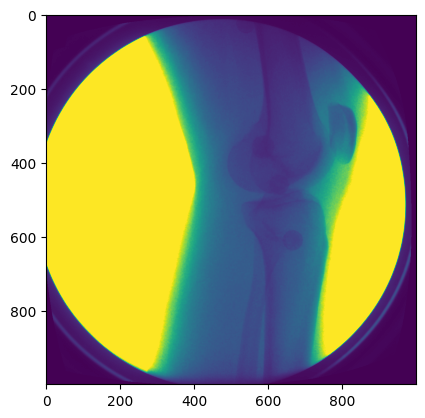

In [107]:
from pathlib import Path
from PIL import Image
xray_id = 1
# specimen, isocenter_pose, transforms, drr = load(5, height=256, device=device, volume_type="tibia")
true_xray, pose, img_xray = specimen[xray_id]

projection = specimen.projections.iloc[xray_id]

base_name = Path(projection["img_path"]).stem



im = Image.open(projection["img_path"])
im = im.resize((256, 256))
if not os.path.exists(project_root+rf"\data\example\{base_name}-256_resize.tif"):
    im.save(project_root+rf"\data\example\{base_name}-256_resize.tif")

iso_gt_pose = isocenter_pose.compose(pose.to(device))
# iso_gt_pose = pose.to(device).compose(isocenter_pose)

pred_xray_pose = drr(None, None, None, pose=pose.to(device))
pred_xray = drr(None, None, None, pose=iso_gt_pose.to(device))

In [108]:
print(pred_xray_pose.shape)
print(pose.get_translation())
print(pose.get_rotation(parameterization="euler_angles", convention="XYZ")*180/torch.pi)
print(type(pred_xray))

torch.Size([1, 1, 256, 256])
tensor([[-229.6815,  -91.6707,  112.5448]])
tensor([[109.6509,  36.7955, 173.1652]])
<class 'torch.Tensor'>


In [109]:
def vis_drr(drr, pose, device):
    pred_xray = drr(None, None, None, pose=pose.to(device))

    #| label: bone_attenuation_multiplier=1.0
#| code-fold: true
#| eval: false
    plt.figure(constrained_layout=True)
    plt.subplot(121)
    plt.title("DRR: " + str(pose.get_rotation("euler_angles", "XYZ")))
    plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")

    plt.show()

In [110]:
def visualize( drr, pose , gt_xray, device):
    from PIL import Image

    transform = T.ToPILImage()
    pred_xray = drr(None, None, None, pose=pose.to(device))
    drr_xray = pred_xray[0,:,:,:]

    # print("drr xray shape", drr_xray.detach().cpu().numpy().shape)
    background = (gt_xray / 256).astype(np.uint8)
    background = background.reshape(256, 256, 1)
    overlay = transform(drr_xray.detach().cpu())
    background = transform(background)

    background = background.convert("RGB")
    overlay = overlay.convert("RGB")
    print('size', background.size)
    print('size', overlay.size)
    new_img = Image.blend(background, overlay, 0.5)
    print(pose.get_translation())
    print(pose.get_rotation("euler_angles", "XYZ"))
    print("unique values in drr", torch.unique(drr_xray))
    plt.figure(constrained_layout=False)
    plt.subplot(121)
    plt.title("DRR: " + str(pose.get_rotation("euler_angles", "XYZ")))
    # drr_xray = pred_xray[0,:,:,:]
    plt.imshow(new_img, cmap="gray")


    # plt.imshow(drr_xray.squeeze().detach().cpu().numpy(), cmap="gray")
    # plt.show()

size (256, 256)
size (256, 256)
tensor([[-229.6815,  -91.6707,  112.5448]])
tensor([[1.9138, 0.6422, 3.0223]])
unique values in drr tensor([0.0000e+00, 1.1150e-03, 1.8113e-03,  ..., 1.7916e+01, 1.8941e+01,
        1.8959e+01], device='cuda:0')


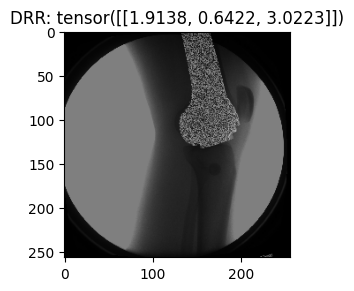

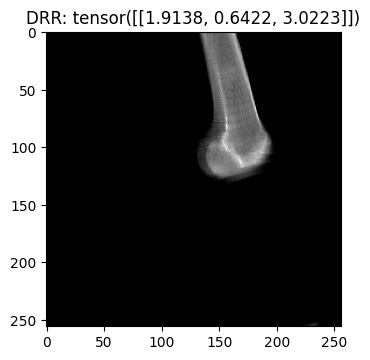

tensor([[15.5447,  5.4685, 36.9917]], device='cuda:0')


In [111]:
img_xray = tiff.imread(project_root+rf"\data\example\{base_name}-256_resize.tif")
visualize(drr=drr, pose=pose, gt_xray=img_xray, device=device)
vis_drr(drr=drr, pose=pose, device=device)
print(iso_gt_pose.get_rotation(parameterization="euler_angles", convention="XYZ")*180/torch.pi)

steps:
check if changing 45 degrees works the same for other examples
check if putting lps2volume in the middle helps..
check if subtracting the translation is a good idea

size (256, 256)
size (256, 256)
tensor([[ -51.1247, -161.9206,  244.2771]])
tensor([[ 1.5135,  0.6222, -3.1192]])
unique values in drr tensor([0.0000e+00, 3.1310e-04, 8.6355e-03, 3.7235e-02, 4.0339e-02, 5.1862e-02,
        9.4012e-02, 1.0009e-01, 1.0863e-01, 1.1264e-01, 1.1999e-01, 1.2774e-01,
        1.2849e-01, 2.0088e-01, 2.0691e-01, 2.5443e-01, 2.7195e-01, 3.1103e-01,
        3.1142e-01, 3.3327e-01, 3.6005e-01, 4.1643e-01, 5.5960e-01, 5.8079e-01,
        6.1021e-01, 6.4221e-01, 6.8202e-01, 6.9296e-01, 6.9917e-01, 7.2151e-01,
        7.3713e-01, 7.7157e-01, 7.8367e-01, 7.9698e-01, 8.0428e-01, 8.4692e-01,
        8.6640e-01, 8.8125e-01, 8.9145e-01, 8.9373e-01, 9.2493e-01, 9.6922e-01,
        9.7330e-01, 9.8763e-01, 9.9099e-01, 1.0040e+00, 1.0044e+00, 1.0132e+00,
        1.0147e+00, 1.0278e+00, 1.1046e+00, 1.1332e+00, 1.1933e+00, 1.2091e+00,
        1.2578e+00, 1.3111e+00, 1.3129e+00, 1.3746e+00, 1.3788e+00, 1.3926e+00,
        1.4061e+00, 1.4148e+00, 1.4175e+00, 1.4454e+00, 1.4474e+0

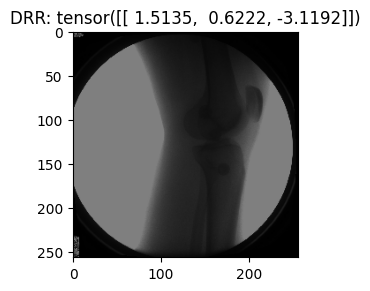

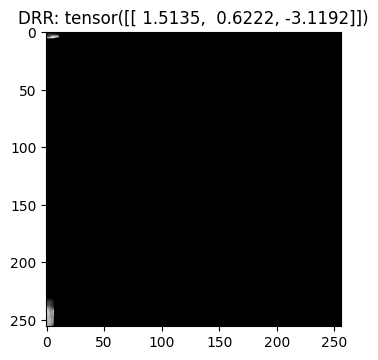

In [49]:
rotation = RigidTransform(torch.tensor([[1.0 , 0, 0], [0, -1, 0], [0, 0, -1]]), torch.zeros(3))
rotation = RigidTransform(torch.tensor([[1.0 , 0, 0], [0, 0, 1], [0, -1, 0]]), torch.zeros(3))
# rotation = RigidTransform(torch.tensor([0, torch.pi/4, 0.0]), torch.zeros(3))

rotation2 = RigidTransform(torch.tensor([[1, 0.0, 0.0], [0, 0.0, 1], [0, -1, 0]]), torch.zeros(3))
rotation3 = RigidTransform(torch.tensor([torch.pi/4, 0 , 0.0]), torch.zeros(3), "euler_angles", "XYZ")

# trans = RigidTransform(torch.tensor([0.0, 0, 0]), torch.tensor([100, -100, 175.0]), "euler_angles", "XYZ")
trans = RigidTransform(torch.tensor([0.0, 0, 0]), torch.tensor([-100, -100, 175.0]), "euler_angles", "XYZ")

# trans = RigidTransform(pose.get_rotation("euler_angles", "XYZ"), torch.tensor([[0, 0.0, 0]]), "euler_angles", "XYZ")

new_pose = trans.compose(pose)

# new_pose = rotation2.compose(rotation).compose(trans).compose(pose)

# new_pose = trans.compose(rotation).compose(pose)

# new_pose = trans.compose(rotation).compose(pose)

# trans = RigidTransform(torch.tensor([0.0, 0, 0]), torch.tensor([0, 0, 200]), "euler_angles", "XYZ")

# new_pose = trans.compose(rotation).compose(pose)
# new_pose = trans.compose(rotation3).compose(rotation).compose(pose)


# new_pose =rotation.compose(specimen.lps2volume.inverse()).compose(pose)
visualize(drr=drr, pose=new_pose, gt_xray=img_xray, device=device)
vis_drr(drr=drr, pose=new_pose, device=device)

print(specimen.lps2volume.inverse())

size (256, 256)
size (256, 256)
tensor([[  0.0000, 100.0000, 175.1974]], device='cuda:0')
tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')
unique values in drr tensor([ 0.0000,  0.0489,  0.0489,  ..., 19.2485, 19.6465, 19.6707],
       device='cuda:0')


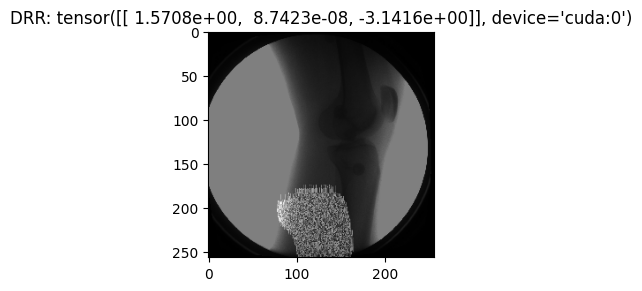

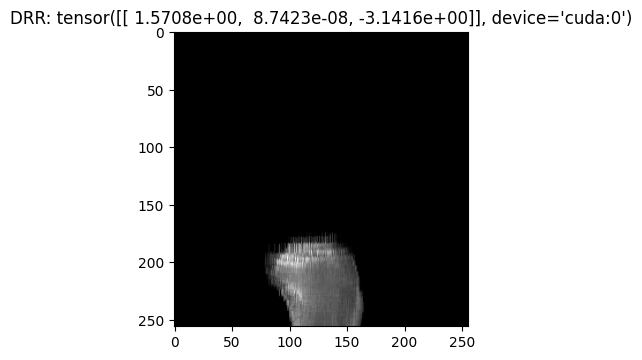

tensor([[-2.5349, -1.0409, 35.6578]], device='cuda:0')


In [50]:
img_xray = tiff.imread(project_root+rf"\data\example\{base_name}-256_resize.tif")
test_pose = RigidTransform(torch.eye(3, device=device, dtype=torch.float32), torch.tensor([-100.0, 0, 0], device=device))
pss = isocenter_pose.compose(test_pose)
visualize(drr=drr, pose=pss, gt_xray=img_xray, device=device)
vis_drr(drr=drr, pose=pss, device=device)
print(iso_gt_pose.get_rotation(parameterization="euler_angles", convention="XYZ")*180/torch.pi)

size (256, 256)
size (256, 256)
tensor([[ -98.9940, -354.5208,   46.7222]], device='cuda:0')
tensor([[-0.0380, -0.0290,  0.8840]], device='cuda:0')
unique values in drr tensor([0.], device='cuda:0')
tensor([[  85.7956,   50.6199, -177.3809]])


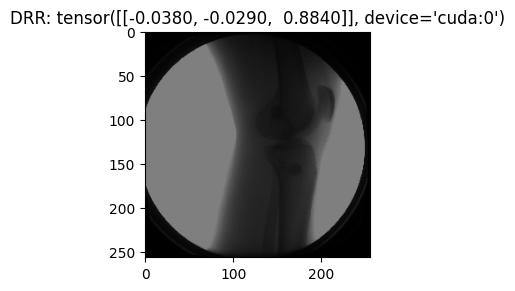

In [22]:
visualize(drr=drr, pose=iso_gt_pose, gt_xray=img_xray,device=device)
print(pose.get_rotation(parameterization="euler_angles", convention="XYZ")*180/torch.pi)

In [23]:

# from random import randint, randrange

# device = 'cuda'
# # best_model_path = r"C:\Users\Public Admin\Desktop\Gitlab\kneedeeppose\notebooks\api\checkpoints\specimen_01_best.ckpt"

# run_id = randint(100, 9999) 

# lr=1e-2
# vol_type = "femur"
# n_batches_per_epoch = 10
# specimen_id = 10
# batch_size = 2
# ckpt_train = None
# epochs = 200
# run = wandb.init(
#     # Set the project where this run will be logged
#     project="KneeDeepPose",
#     # Track hyperparameters and run metadata
#     config={
#         "vol_type" : vol_type ,
#         "specimen" : specimen_id,
#         "batch_size" : batch_size,
#         "ckpt":ckpt_train,
#         "n_batches_per_epoch":n_batches_per_epoch,
#         "learning_rate": lr,
#         "optimizer" : "Adam",
#         "PoseRegressor":"default",
#     },
#     name = str(vol_type)+"_" +str(specimen_id) + "_" + str(run_id)
# )


# main(run_id=run_id, id_number=specimen_id, device=device, height=256,  volume_type=vol_type, restart=ckpt_train, skip_training=False, skip_finetuning=True,model_name="resnet18",parameterization="se3_log_map", convention=None, lr=lr, batch_size=batch_size, n_epochs=epochs,  n_batches_per_epoch=n_batches_per_epoch)


# torch.cuda.empty_cache()

In [24]:
def gen_random_offset(batch_size, device):

    # rotation along x is good
    r1 = torch.distributions.Normal(0, 0.3*torch.pi).sample((batch_size,))
    r2 = torch.distributions.Normal(0, 0.01*torch.pi).sample((batch_size,))
    # r3 = torch.tensor([-0.7])
    r3 = torch.distributions.Normal(0, 0.1*torch.pi).sample((batch_size,))

    print('this is r1', r2)
    # r1, r2, r3 = torch.tensor([0.3*torch.pi, -0.3*torch.pi, 0.0,0.0]),torch.tensor([0.01*torch.pi, -0.01*torch.pi, 0.0, 0.0]), torch.tensor([0.1*torch.pi, -0.1*torch.pi, -0.1*torch.pi, 1.2*torch.pi])

    r1_se3 = torch.distributions.Normal(0, 2.1).sample((batch_size,))
    r2_se3 = torch.distributions.Normal(0, 1.5).sample((batch_size,))
    r3_se3 = torch.distributions.Normal(0, 0.5).sample((batch_size,))
    # r1_se3, r2_se3, r3_se3 = torch.tensor([2, -2, 2, -2]), torch.tensor([0.0, -0.0, 1, -1]), torch.tensor([0.1, -0.1,0.1, -0.1])


    
    t1 = torch.distributions.Normal(-50, 1).sample((batch_size,))
    t2 = torch.distributions.Normal(0, 50).sample((batch_size,))
    t3 = torch.distributions.Normal(-30, 50).sample((batch_size,))

    # t1, t2, t3 = torch.tensor([-50.0, -50.0, -050.0, -050.0]), torch.tensor([50.0, -50.0, 100, -100]), torch.tensor([50.0, -50.0,  100, -100])


    # for i in torch.nonzero(r2 < 0).squeeze():
    #     mu = float(-250*r2[i])
    #     sigma = float(2*r2[i])
    #     print('this is t1[i]', mu, sigma)
    #     t1[i] = float(torch.distributions.Normal(mu, sigma).sample()[0])
    # for i in torch.nonzero(r3 < 0).squeeze():
    #     t2[i] = float(torch.distributions.Normal(float(-100*r3[i]), float(2*r3[i])).sample()[0])

    # t1, t3 = torch.tensor([0.0]), torch.tensor([0.0])
    # t2 = torch.tensor([100])
    # t1 = torch.tensor([0])



    rot =  torch.stack([r1, r2, r3], dim=1).to(device)
    trans = torch.stack([t1, t2, t3], dim=1).to(device)

    rot_se3 =  torch.stack([r1_se3, r2_se3, r3_se3], dim=1).to(device)
    trans_se3 = torch.stack([t1, t2, t3], dim=1).to(device)

    rand_T = RigidTransform(rot, trans, "euler_angles", "XYZ")
    rand_T_se3 = convert(
        [rot_se3, trans_se3],
        "se3_log_map",
        "se3_exp_map",
    )


    return rand_T, rand_T_se3


ISO
tensor([[100.0000, 100.0000, 175.1974]], device='cuda:0')
tensor([[[-1.0000e+00,  0.0000e+00,  8.7423e-08],
         [-8.7423e-08, -4.3711e-08, -1.0000e+00],
         [ 3.8214e-15, -1.0000e+00,  4.3711e-08]]], device='cuda:0')
tensor([[ 1.5708e+00,  8.7423e-08, -3.1416e+00]], device='cuda:0')


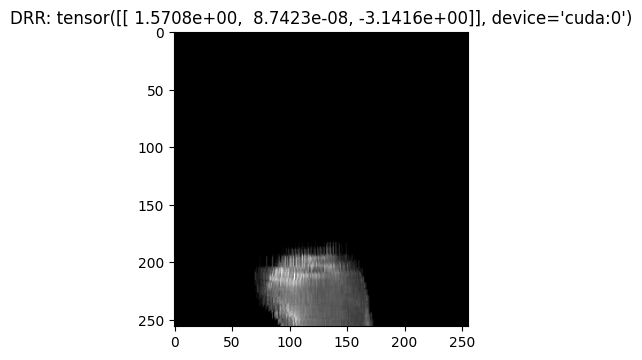

this is r1 tensor([ 0.0026,  0.0896, -0.0111,  0.0190, -0.0108,  0.0112,  0.0006, -0.0025,
         0.0231,  0.0033])
OFFSET


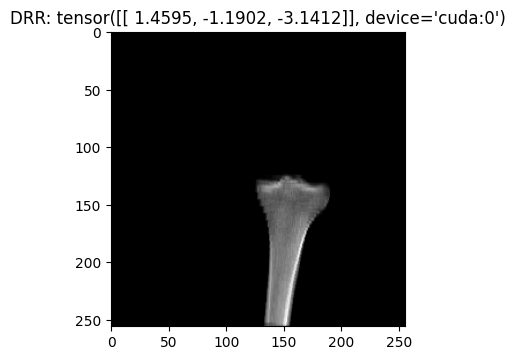

tensor([-30.3769, 536.9916,  87.2895], device='cuda:0') tensor([[-3.7146e-01,  1.3925e-04, -9.2845e-01],
        [ 9.2266e-01, -1.1144e-01, -3.6916e-01],
        [-1.0352e-01, -9.9377e-01,  4.1267e-02]], device='cuda:0')


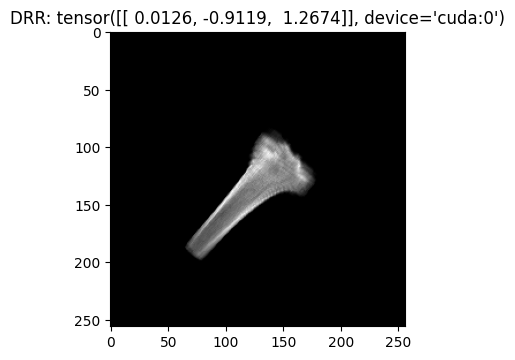

tensor([199.8129, 547.5407, 207.5338], device='cuda:0') tensor([[ 0.1829, -0.5843, -0.7907],
        [ 0.9513,  0.3082, -0.0077],
        [ 0.2482, -0.7508,  0.6122]], device='cuda:0')


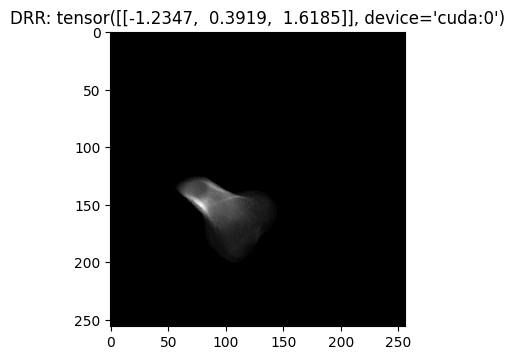

tensor([ 120.8992,  244.5650, -280.4012], device='cuda:0') tensor([[-0.0441, -0.9232,  0.3819],
        [ 0.3466,  0.3444,  0.8725],
        [-0.9370,  0.1708,  0.3048]], device='cuda:0')


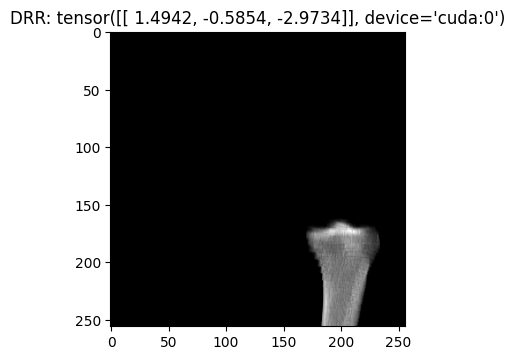

tensor([-228.4386,  422.9941,   77.6330], device='cuda:0') tensor([[-0.8217,  0.1395, -0.5525],
        [ 0.5303, -0.1677, -0.8311],
        [-0.2086, -0.9759,  0.0638]], device='cuda:0')


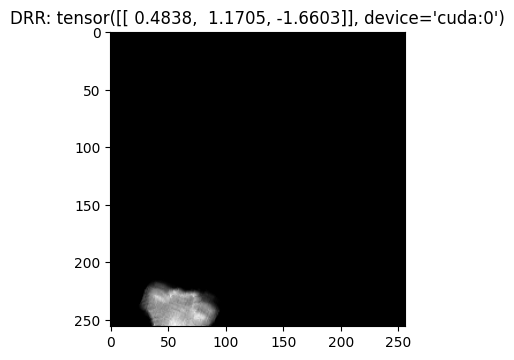

tensor([ 101.8729, -335.4386,   80.2235], device='cuda:0') tensor([[-0.0348,  0.3881,  0.9210],
        [-0.9200,  0.3476, -0.1813],
        [-0.3905, -0.8535,  0.3449]], device='cuda:0')


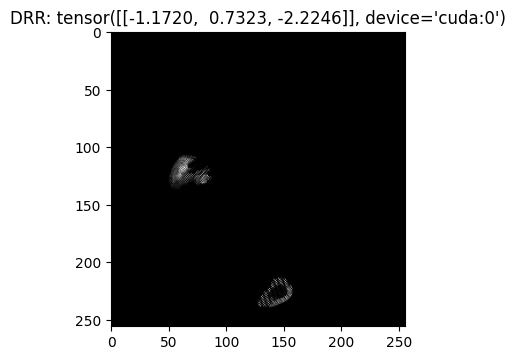

tensor([-92.7998, 169.1299, 588.0504], device='cuda:0') tensor([[-0.4523,  0.5903,  0.6686],
        [ 0.0665, -0.7252,  0.6853],
        [ 0.8894,  0.3544,  0.2887]], device='cuda:0')


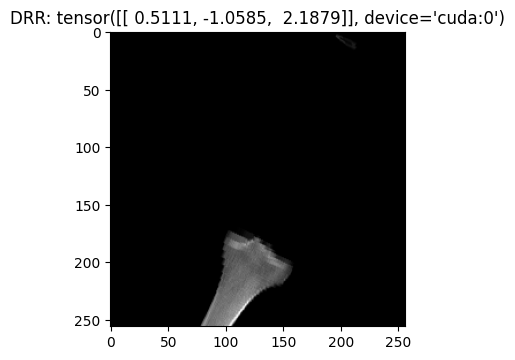

tensor([  7.5219, 547.1301, 168.5741], device='cuda:0') tensor([[-0.2837, -0.3998, -0.8716],
        [ 0.9581, -0.1570, -0.2398],
        [-0.0409, -0.9031,  0.4276]], device='cuda:0')


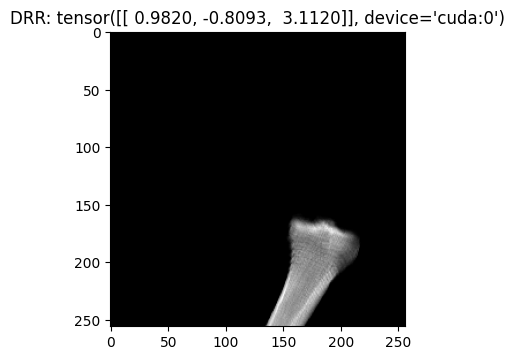

tensor([-159.2017,  449.9352,  -27.1227], device='cuda:0') tensor([[-0.6897, -0.0204, -0.7238],
        [ 0.6181, -0.5373, -0.5738],
        [-0.3772, -0.8431,  0.3832]], device='cuda:0')


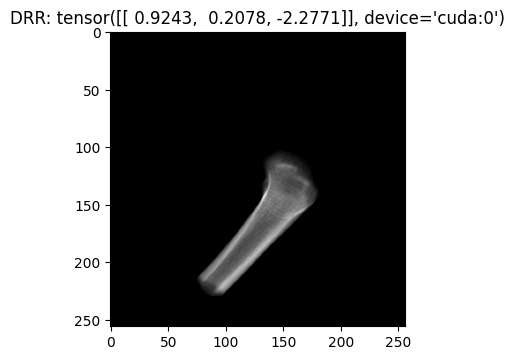

tensor([-165.5737, -100.6336, -108.3406], device='cuda:0') tensor([[-0.6350,  0.7444,  0.2064],
        [-0.5652, -0.2656, -0.7810],
        [-0.5266, -0.6126,  0.5894]], device='cuda:0')


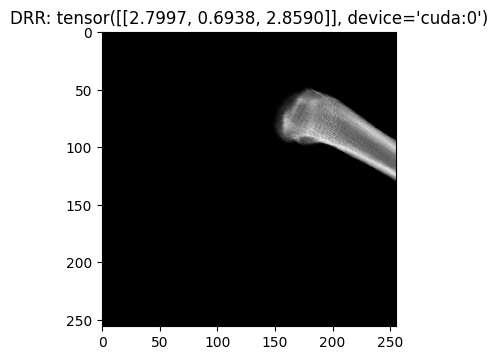

tensor([-245.1037,  -24.1873,  -59.6183], device='cuda:0') tensor([[-0.7383, -0.2144,  0.6394],
        [-0.4686,  0.8450, -0.2578],
        [-0.4851, -0.4899, -0.7243]], device='cuda:0')


In [25]:
print("ISO")

print(isocenter_pose.get_translation())
print(isocenter_pose.get_rotation())

print(isocenter_pose.get_rotation("euler_angles", "XYZ"))

vis_drr(drr, isocenter_pose, device=device)


offset, offset_se3 = gen_random_offset(10, device=device)
print("OFFSET")
new_poses = offset.compose(isocenter_pose)
trans = new_poses.get_translation()
rot = new_poses.get_rotation("euler_angles","XYZ")

# new_poses_se3 = isocenter_pose.compose(offset_se3)
transito = RigidTransform(torch.eye(3, dtype=torch.float32, device=device), torch.tensor([972/2, 0,0], dtype=torch.float32, device=device))
# new_poses_se3 = transito.compose(offset_se3.compose(isocenter_pose))
new_poses_se3 = transito.compose(offset_se3.compose(isocenter_pose))


trans_se3 = new_poses_se3.get_translation()
rot_se3 = new_poses_se3.get_rotation()

# for i,j in zip(trans,rot):
#     vis_drr(drr, RigidTransform(j,i, "euler_angles", "XYZ"), device=device)
#     # vis_drr(drr, RigidTransform(l,k, "euler_angles", "XYZ"), device=device)
#     print(i,j)

for i,j in zip(trans_se3,rot_se3):
    # vis_drr(drr, RigidTransform(j,i, "euler_angles", "XYZ"), device=device)
    vis_drr(drr, RigidTransform(j,i), device=device)
    print(i,j)


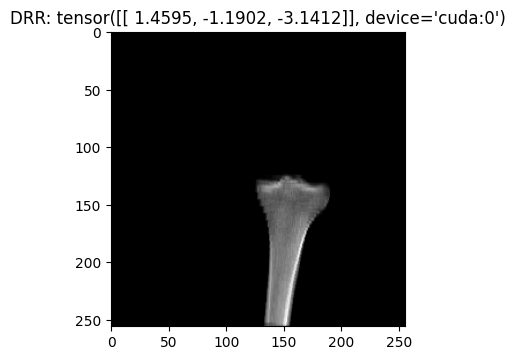

tensor([-30.3769, 536.9916,  87.2895], device='cuda:0') tensor([[-3.7146e-01,  1.3925e-04, -9.2845e-01],
        [ 9.2266e-01, -1.1144e-01, -3.6916e-01],
        [-1.0352e-01, -9.9377e-01,  4.1267e-02]], device='cuda:0')


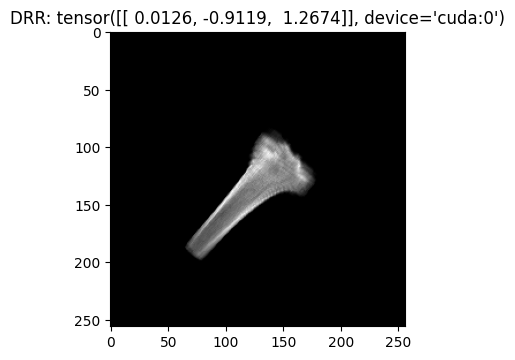

tensor([199.8129, 547.5407, 207.5338], device='cuda:0') tensor([[ 0.1829, -0.5843, -0.7907],
        [ 0.9513,  0.3082, -0.0077],
        [ 0.2482, -0.7508,  0.6122]], device='cuda:0')


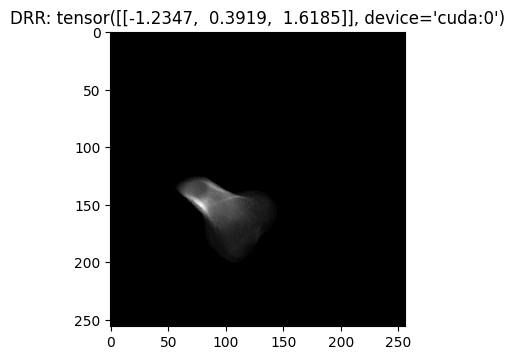

tensor([ 120.8992,  244.5650, -280.4012], device='cuda:0') tensor([[-0.0441, -0.9232,  0.3819],
        [ 0.3466,  0.3444,  0.8725],
        [-0.9370,  0.1708,  0.3048]], device='cuda:0')


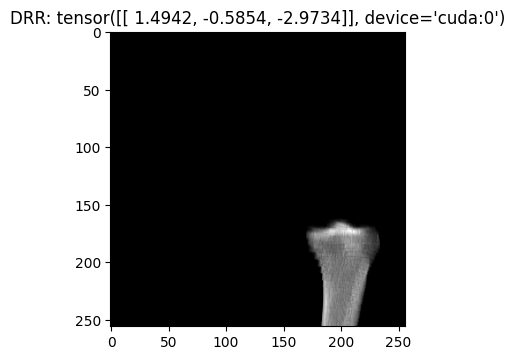

tensor([-228.4386,  422.9941,   77.6330], device='cuda:0') tensor([[-0.8217,  0.1395, -0.5525],
        [ 0.5303, -0.1677, -0.8311],
        [-0.2086, -0.9759,  0.0638]], device='cuda:0')


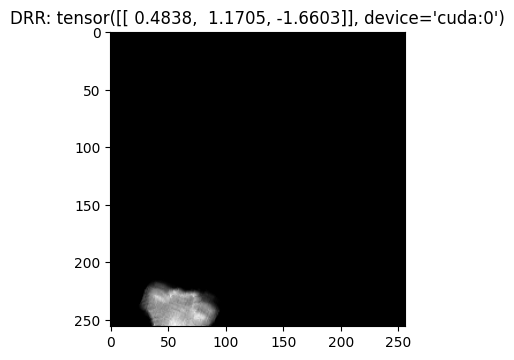

tensor([ 101.8729, -335.4386,   80.2235], device='cuda:0') tensor([[-0.0348,  0.3881,  0.9210],
        [-0.9200,  0.3476, -0.1813],
        [-0.3905, -0.8535,  0.3449]], device='cuda:0')


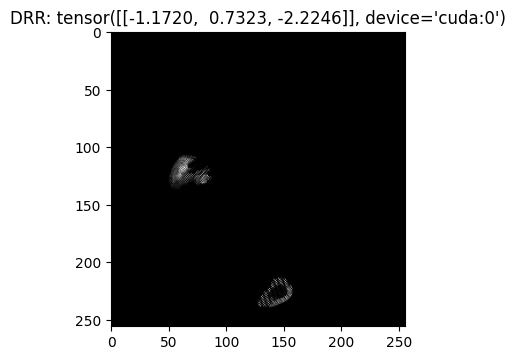

tensor([-92.7998, 169.1299, 588.0504], device='cuda:0') tensor([[-0.4523,  0.5903,  0.6686],
        [ 0.0665, -0.7252,  0.6853],
        [ 0.8894,  0.3544,  0.2887]], device='cuda:0')


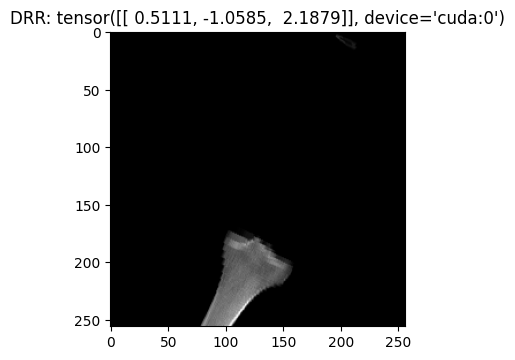

tensor([  7.5219, 547.1301, 168.5741], device='cuda:0') tensor([[-0.2837, -0.3998, -0.8716],
        [ 0.9581, -0.1570, -0.2398],
        [-0.0409, -0.9031,  0.4276]], device='cuda:0')


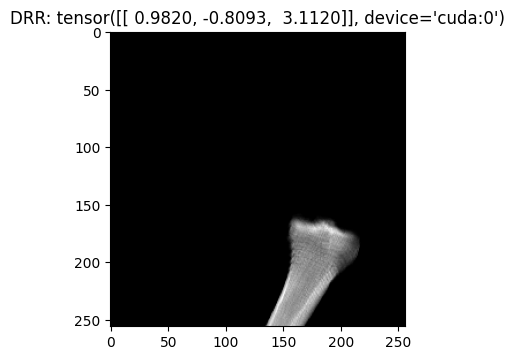

tensor([-159.2017,  449.9352,  -27.1227], device='cuda:0') tensor([[-0.6897, -0.0204, -0.7238],
        [ 0.6181, -0.5373, -0.5738],
        [-0.3772, -0.8431,  0.3832]], device='cuda:0')


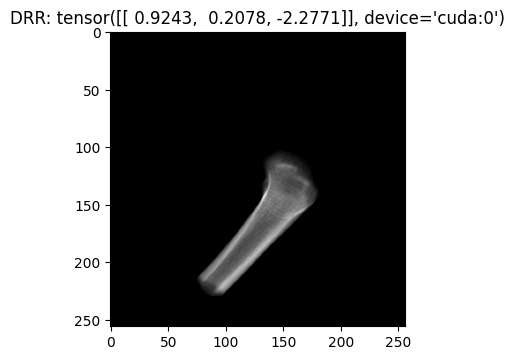

tensor([-165.5737, -100.6336, -108.3406], device='cuda:0') tensor([[-0.6350,  0.7444,  0.2064],
        [-0.5652, -0.2656, -0.7810],
        [-0.5266, -0.6126,  0.5894]], device='cuda:0')


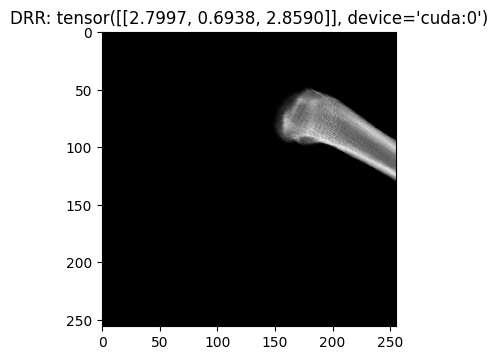

tensor([-245.1037,  -24.1873,  -59.6183], device='cuda:0') tensor([[-0.7383, -0.2144,  0.6394],
        [-0.4686,  0.8450, -0.2578],
        [-0.4851, -0.4899, -0.7243]], device='cuda:0')


In [26]:
new_poses_se3 = transito.compose(offset_se3.compose(isocenter_pose))


trans_se3 = new_poses_se3.get_translation()
rot_se3 = new_poses_se3.get_rotation()

# for i,j in zip(trans,rot):
#     vis_drr(drr, RigidTransform(j,i, "euler_angles", "XYZ"), device=device)
#     # vis_drr(drr, RigidTransform(l,k, "euler_angles", "XYZ"), device=device)
#     print(i,j)

for i,j in zip(trans_se3,rot_se3):
    # vis_drr(drr, RigidTransform(j,i, "euler_angles", "XYZ"), device=device)
    vis_drr(drr, RigidTransform(j,i), device=device)
    print(i,j)


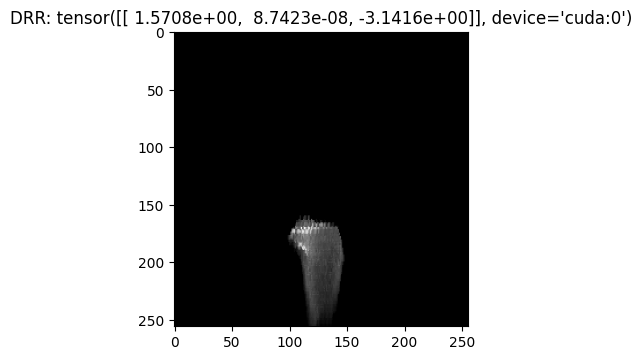

In [27]:
new_poses_se3 = transito.compose(isocenter_pose)

vis_drr(drr, new_poses_se3, device=device)

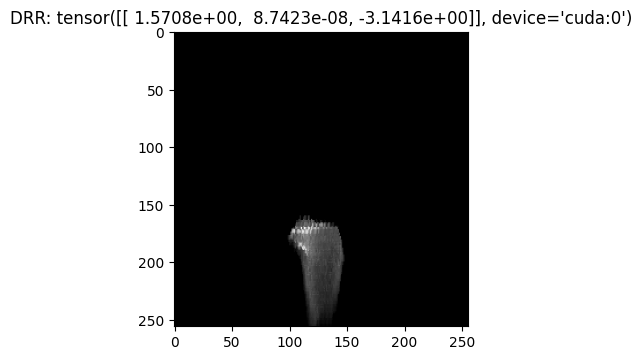

In [28]:
new_poses_se3 = transito.compose(isocenter_pose)

vis_drr(drr, new_poses_se3, device=device)

size (256, 256)
size (256, 256)
tensor([[  88.1772,  123.5610,  135.8354],
        [  49.8593,  127.3027,  177.1604],
        [  80.5053,  158.5203,   28.2560],
        [  24.1719,   99.4367,  102.7489],
        [  47.5031,  109.9533,   62.7612],
        [   6.0837, -134.8356,  176.0402],
        [  58.2144, -126.6448,  155.0011],
        [  77.0782,  -79.0329,   82.1506],
        [  83.8067,   29.1080,  110.8049],
        [  16.2649,  260.4395,  -16.0314]], device='cuda:0')
tensor([[ 1.2766, -0.5334,  3.1386],
        [ 1.9389,  0.1435,  3.0511],
        [ 0.6222, -0.4368, -3.1293],
        [ 1.6893,  0.2573,  3.1220],
        [ 0.7732, -0.0098, -3.1308],
        [ 2.7100,  0.3844,  3.1295],
        [ 2.6380, -0.0812,  3.1410],
        [ 2.4052, -0.3348, -3.1390],
        [ 1.8634, -0.3730,  3.1167],
        [ 0.9392,  0.2976,  3.1381]], device='cuda:0')
unique values in drr tensor([0.0000e+00, 5.1745e-04, 1.3398e-03,  ..., 1.4494e+01, 1.4803e+01,
        1.4872e+01], device='cuda:0')

TypeError: Invalid shape (10, 256, 256) for image data

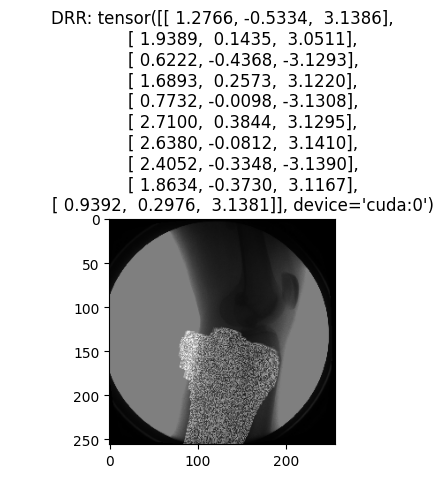

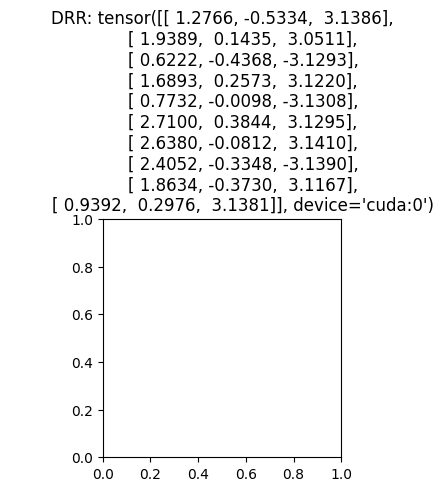

In [29]:
# visualize(drr=drr, pose=new_poses, gt_xray=img_xray,device=device)
visualize(drr=drr, pose=isocenter_pose.compose(offset), gt_xray=img_xray,device=device)
vis_drr(drr=drr, pose=isocenter_pose.compose(offset), device=device)


size (256, 256)
size (256, 256)
tensor([[150.0455, 140.3463, 191.8291]], device='cuda:0')
tensor([[1.1854, 0.0335, 3.0288]], device='cuda:0')
unique values in drr tensor([0.0000e+00, 1.2685e-03, 1.8517e-03,  ..., 1.8010e+01, 1.8146e+01,
        1.8190e+01], device='cuda:0')


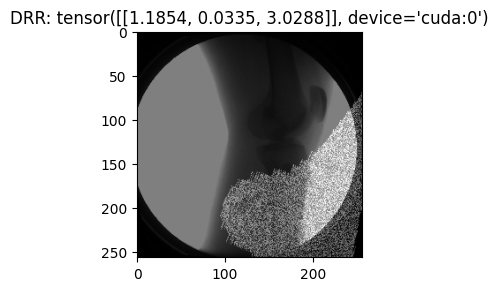

In [556]:
visualize(drr=drr, pose=new_poses, gt_xray=img_xray,device=device)


In [ ]:
a = torch.tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -4.3711e-08,  1.0000e+00],
         [ 0.0000e+00, -1.0000e+00, -4.3711e-08]]])

b = torch.tensor([[[-0.7925,  0.4455,  0.4165],
         [ 0.1837, -0.4768,  0.8596],
         [ 0.5815,  0.7577,  0.2960]]])

print(torch.matmul(b,a))
print(torch.matmul(b,torch.tensor([[586.0000], [100.0000], [175.1974]])) + torch.tensor([[ 5.5801], [-3.6801], [-9.9500]]))

tensor([[[-0.7925, -0.4165,  0.4455],
         [ 0.1837, -0.8596, -0.4768],
         [ 0.5815, -0.2960,  0.7577]]])
tensor([[[-341.3052],
         [ 206.8878],
         [ 458.4374]]])


In [ ]:
xs = [1, 2, 3]
import statistics
statistics.mean(xs)

2

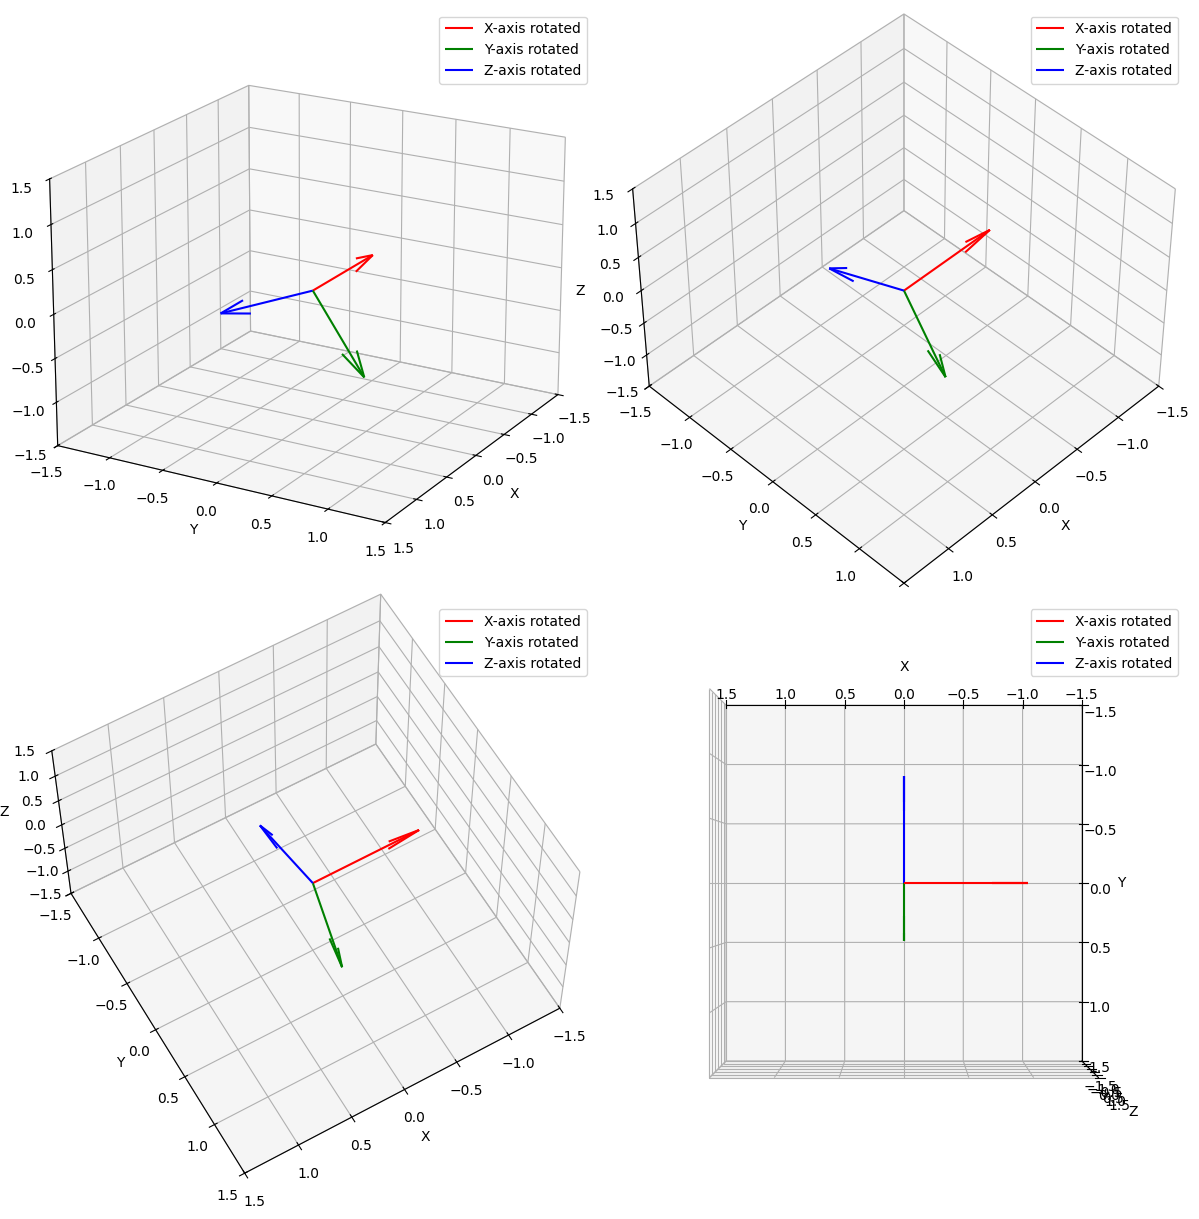

In [ ]:
# plot my rotation


def plot_vector(ax, vec, color, label):
    """
    Plot a 3D vector starting from the origin.
    """
    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=color, label=label)

# Create the figure and the 3D axis
fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111, projection='3d')

# Original basis vectors
x = np.array([1, 0, 0])
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])

# Define different views
views = [(20, 30), (45, 45), (60, 60), (90, 90)]
axes = [fig.add_subplot(2, 2, i + 1, projection='3d') for i in range(4)]

# Plot original basis vectors
# plot_vector(ax, x, 'r', 'X-axis')
# plot_vector(ax, y, 'g', 'Y-axis')
# plot_vector(ax, z, 'b', 'Z-axis')

# Define the axis of rotation and angle (in radians)
axis = np.array([1, 1, 0])
theta = np.pi / 4  # 45 degrees

R = np.array(pose.cpu().get_rotation().squeeze())
R = np.array(pose.compose(offset).cpu().get_rotation().squeeze())

# R = np.array([[ 0.9827,  0.1686,  0.0768],
#          [-0.1827,  0.8118,  0.5547],
#          [ 0.0312, -0.5591,  0.8285]])

# axis = np.array([[-104.1493,   -1.5889,   12.7688]])
# R = rotation_matrix(axis, theta)

# Rotate the basis vectors
x_rot = R @ x
y_rot = R @ y
z_rot = R @ z

for ax, (elev, azim) in zip(axes, views):

    # Plot rotated basis vectors
    plot_vector(ax, x_rot, 'r', 'X-axis rotated')
    plot_vector(ax, y_rot, 'g', 'Y-axis rotated')
    plot_vector(ax, z_rot, 'b', 'Z-axis rotated')

    # Setting the plot
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)  # Set the view angle
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# plot my rotation


def plot_vector(ax, vec, color, label):
    """
    Plot a 3D vector starting from the origin.
    """
    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=color, label=label)

# Create the figure and the 3D axis
fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111, projection='3d')

# Original basis vectors
x = np.array([1, 0, 0])
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])

# Define different views
views = [(20, 30), (45, 45), (60, 60), (90, 90)]
axes = [fig.add_subplot(2, 2, i + 1, projection='3d') for i in range(4)]

# Plot original basis vectors
# plot_vector(ax, x, 'r', 'X-axis')
# plot_vector(ax, y, 'g', 'Y-axis')
# plot_vector(ax, z, 'b', 'Z-axis')

# Define the axis of rotation and angle (in radians)
axis = np.array([1, 1, 0])
theta = np.pi / 4  # 45 degrees

R = np.array(pose.cpu().get_rotation().squeeze())
R = np.array(pose.compose(offset).cpu().get_rotation().squeeze())

# R = np.array([[ 0.9827,  0.1686,  0.0768],
#          [-0.1827,  0.8118,  0.5547],
#          [ 0.0312, -0.5591,  0.8285]])

# axis = np.array([[-104.1493,   -1.5889,   12.7688]])
# R = rotation_matrix(axis, theta)

# Rotate the basis vectors
x_rot = R @ x
y_rot = R @ y
z_rot = R @ z

for ax, (elev, azim) in zip(axes, views):

    # Plot rotated basis vectors
    plot_vector(ax, x_rot, 'r', 'X-axis rotated')
    plot_vector(ax, y_rot, 'g', 'Y-axis rotated')
    plot_vector(ax, z_rot, 'b', 'Z-axis rotated')

    # Setting the plot
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)  # Set the view angle
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
###################################### CREATING OFFSET ######################################
offset_rot = torch.tensor([torch.pi/2,0, 0])
offset_trans = torch.tensor([0.0, 0, 0])
offset = RigidTransform(offset_rot, offset_trans, "euler_angles", "XYZ", device=device, dtype=torch.float32)
offset1 = offset.compose(isocenter_pose).to(device)

print("isocenter.compose(offset)")
print("translation", offset1.get_translation())
vis_drr(drr, offset1, device=device)
print("translation", isocenter_pose.get_rotation())
print("translation", offset1.get_rotation())

### translate in x, moves back in x
translated = offset1.compose(RigidTransform(torch.eye(3, device=device, dtype=torch.float32).unsqueeze(0), torch.tensor([[-specimen.focal_len/2, 0, 0]])).to(device))

print("x translated")
print('translated translation ', translated.get_translation())
vis_drr(drr, translated, device=device)

# translated = torch.matmul(offset.get_rotation()[:,0], specimen.translate.to(device).get_translation().T)
print(offset1.get_rotation()[:,0])
offset_trans_x = offset1.get_rotation()[:,0] * specimen.focal_len
print(offset_trans_x)

offset_trans_x = offset_trans_x.to(device)
print(offset.get_rotation())

print('offset.get_translation()', offset.get_translation())
print(' offset_trans_x.squeeze()', offset_trans_x)

final_offset = RigidTransform(offset1.get_rotation(), offset1.get_translation() + offset_trans_x, device=device, dtype=torch.float32)

# offset_trans_x = torch.tensor([[-840.4724, -468.4908, 170.3723]]).to(device)
final_offset = offset1.compose(RigidTransform(torch.eye(3, device=device, dtype=torch.float32).unsqueeze(0), offset_trans_x))

print('final_offset translation', final_offset.get_translation())


vis_drr(drr, final_offset, device=device)



isocenter_pose2 = RigidTransform(torch.tensor([-torch.pi/2, -torch.pi, 0], device=device, dtype=torch.float32).unsqueeze(0), torch.tensor([-386.0000, 100, 175], device=device, dtype=torch.float32).unsqueeze(0), "euler_angles", "XYZ")
vis_drr(drr, isocenter_pose2, device=device)

offset2 = isocenter_pose2.compose(RigidTransform(torch.eye(3, device=device, dtype=torch.float32).unsqueeze(0), torch.tensor([-100, 100, 0], device=device, dtype=torch.float32).unsqueeze(0)))
# new_pose = isocenter_pose.compose(offset)

vis_drr(drr, offset2, device=device)

# new_poses = isocenter_pose.compose(offset)
# new_poses = offset.compose(isocenter_pose)

# print("ISO.COMPOSE(OFFSET)")
# print(new_poses.get_translation())
# print(new_poses.get_rotation())

# print(new_poses.get_rotation("euler_angles","XYZ"))


# newnew_pose = isocenter_pose.compose(RigidTransform(torch.eye(3, device=device, dtype=torch.float32).unsqueeze(0), offset.get_translation())).compose(RigidTransform(offset.get_rotation(), torch.zeros(3, device=device, dtype=torch.float32).unsqueeze(0)))
# newnew_pose = isocenter_pose.compose(RigidTransform(torch.tensor([0.1,0.1,0.1], device=device, dtype=torch.float32), torch.tensor([10,20,30], device=device, dtype=torch.float32), "euler_angles", "XYZ"))
# print("ISO.COMPOSE(Translate).compose(rotate)")
# print(newnew_pose.get_translation())
# print(newnew_pose.get_rotation())

# print(newnew_pose.get_rotation("euler_angles","XYZ"))

In [ ]:
test_pose = RigidTransform(pose.get_rotation(), -torch.flip(pose.get_translation(), [0,1]))
visualize(drr=drr, pose=test_pose, device=device)

TypeError: visualize() missing 1 required positional argument: 'gt_xray'

In [ ]:
a = torch.tensor([1,2,3])
b = torch.flip(a, [0,1])
b

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

### tibia experimentation

In [47]:
#| eval: false
# Rotate the C-arm by the pose parameters to recover the original image
device = 'cuda'
# specimen, isocenter_pose, transforms, drr = load(5, height=256, device=device, volume_type="femur")
# final_model, specimen, drr, isocenter_pose = main(1, volume_type="femur", skip_training=True)


# subn02 - 1, subn05 - 3, subn14 - 10, subn07 - 5
pid = 1
final_model, specimen, drr, isocenter_pose = main(pid, volume_type="tibia", skip_training=True)




[0.390625, 0.390625, 0.800018]
affine transformation matrix [[  -0.390625      0.            0.          100.        ]
 [   0.           -0.390625      0.          100.        ]
 [   0.            0.            0.80001801 -175.20394897]
 [   0.            0.            0.            1.        ]]
isocenter_xyz = tensor([512, 512, 438]) * [0.390625 0.390625 0.800018] / 2
ISO XYZ =  tensor([ 100., -100.,  175.])
ISO XYZ =  tensor([[586.0000, 100.0000, 175.2039]], dtype=torch.float64)


get item called
<class 'numpy.ndarray'>
(1000, 1000)
torch.Size([1, 1, 1000, 1000])
lps 2 volume tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]) tensor([[-100.0000, -100.0000,  175.2039]])
pose tensor([[[ 0.2209,  0.9442, -0.2444],
         [ 0.0278,  0.2443,  0.9693],
         [ 0.9749, -0.2209,  0.0277]]]) tensor([[-116.4020, -196.0950, -947.3260]])
extrinsic inverse tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]) tensor([[  -5.7096,   -5.8591, -972.2564]])
translation tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]) tensor([[-486.1282,    0.0000,    0.0000]])


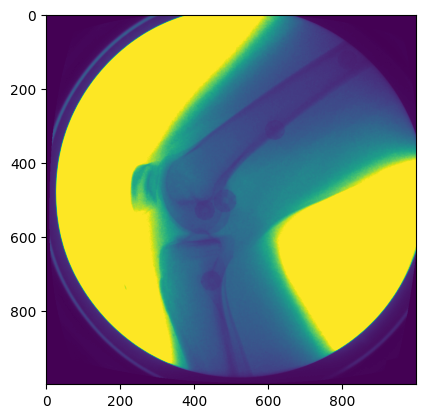

In [48]:
from pathlib import Path
from PIL import Image
# specimen, isocenter_pose, transforms, drr = load(5, height=256, device=device, volume_type="tibia")
true_xray, pose, img_xray = specimen[21]

projection = specimen.projections.iloc[21]

base_name = Path(projection["img_path"]).stem



im = Image.open(projection["img_path"])
im = im.resize((256, 256))
if not os.path.exists(project_root+rf"\data\example\{base_name}-256_resize.tif"):
    im.save(project_root+rf"\data\example\{base_name}-256_resize.tif")

iso_gt_pose = isocenter_pose.compose(pose.to(device))
# iso_gt_pose = pose.to(device).compose(isocenter_pose)

pred_pose = drr(None, None, None, pose=pose.to(device))
pred_iso_gt_pose = drr(None, None, None, pose=iso_gt_pose.to(device))

isocenter_xray = drr(None, None, None, pose=isocenter_pose)

In [49]:
print(pred_xray_pose.shape)
print(pose.get_translation())
print(pose.get_rotation(parameterization="euler_angles", convention="XYZ")*180/torch.pi)
print(type(pred_xray))

torch.Size([1, 1, 256, 256])
tensor([[1503.9924,  -59.3461, -281.4343]])
tensor([[-104.1493,   -1.5889, -167.2312]])
<class 'torch.Tensor'>


In [50]:
def visualize_old( drr, pose , device):
    
    pred_xray = drr(None, None, None, pose=pose.to(device))
    print(pose.get_translation())
    print(pose.get_rotation())
    xray = pred_xray[0,:,:,:]
    plt.figure(constrained_layout=False)
    plt.subplot(121)
    plt.title("DRR")
    plt.imshow(xray.squeeze().detach().cpu().numpy(), cmap="gray")
    plt.show()

In [ ]:
def visualize( drr, pose , gt_xray, device):
    from PIL import Image

    transform = T.ToPILImage()
    pred_xray = drr(None, None, None, pose=pose.to(device))
    drr_xray = pred_xray[0,:,:,:]

    # print("drr xray shape", drr_xray.detach().cpu().numpy().shape)
    background = (gt_xray / 256).astype(np.uint8)
    background = background.reshape(256, 256, 1)
    overlay = transform(drr_xray.detach().cpu())
    background = transform(background)

    background = background.convert("RGB")
    overlay = overlay.convert("RGB")
    print('size', background.size)
    print('size', overlay.size)
    new_img = Image.blend(background, overlay, 0.5)
    print(pose.get_translation())
    print(pose.get_rotation())
    print("unique values in drr", torch.unique(drr_xray))
    plt.figure(constrained_layout=False)
    plt.subplot(121)
    plt.title("DRR")
    # drr_xray = pred_xray[0,:,:,:]
    plt.imshow(new_img, cmap="gray")


    # plt.imshow(drr_xray.squeeze().detach().cpu().numpy(), cmap="gray")
    # plt.show()

size (256, 256)
size (256, 256)
tensor([[ 949.9391,  151.2059, -100.3678]], device='cuda:0')
tensor([[[-0.9749,  0.0277,  0.2209],
         [ 0.0278, -0.9693,  0.2443],
         [ 0.2209,  0.2444,  0.9442]]], device='cuda:0')
unique values in drr tensor([0.], device='cuda:0')
tensor([[ -14.5093,   12.7638, -178.3708]], device='cuda:0')


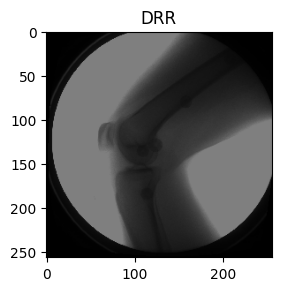

In [51]:
img_xray = tiff.imread(project_root+rf"\data\example\{base_name}-256_resize.tif")
visualize(drr=drr, pose=iso_gt_pose, gt_xray=img_xray, device=device)
# visualize_old(drr=drr, pose=iso_gt_pose, device=device)
print(iso_gt_pose.get_rotation(parameterization="euler_angles", convention="XYZ")*180/torch.pi)

size (256, 256)
size (256, 256)
tensor([[1503.9924,  -59.3461, -281.4343]])
tensor([[[-0.9749,  0.2209, -0.0277],
         [ 0.0278,  0.2443,  0.9693],
         [ 0.2209,  0.9442, -0.2444]]])
unique values in drr tensor([0.], device='cuda:0')
tensor([[-104.1493,   -1.5889, -167.2312]])


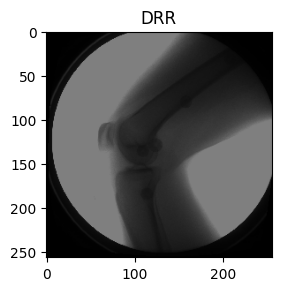

In [52]:
visualize(drr=drr, pose=pose, gt_xray=img_xray,device=device)
print(pose.get_rotation(parameterization="euler_angles", convention="XYZ")*180/torch.pi)

size (256, 256)
size (256, 256)
tensor([[586.0000, 100.0000, 175.2039]], device='cuda:0')
tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -4.3711e-08,  1.0000e+00],
         [ 0.0000e+00, -1.0000e+00, -4.3711e-08]]], device='cuda:0')
unique values in drr tensor([ 0.0000,  0.0394,  0.0934,  ..., 23.4995, 23.4999, 23.5904],
       device='cuda:0')
tensor([[586.0000, 100.0000, 175.2039]], device='cuda:0')
tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -4.3711e-08,  1.0000e+00],
         [ 0.0000e+00, -1.0000e+00, -4.3711e-08]]], device='cuda:0')


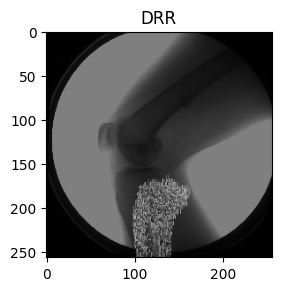

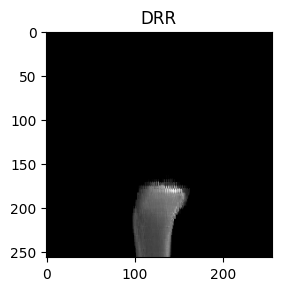

In [53]:
img_xray = tiff.imread(project_root+rf"\data\example\{base_name}-256_resize.tif")
visualize(drr=drr, pose=isocenter_pose, gt_xray=img_xray, device=device)
visualize_old(drr=drr, pose=isocenter_pose,device=device)


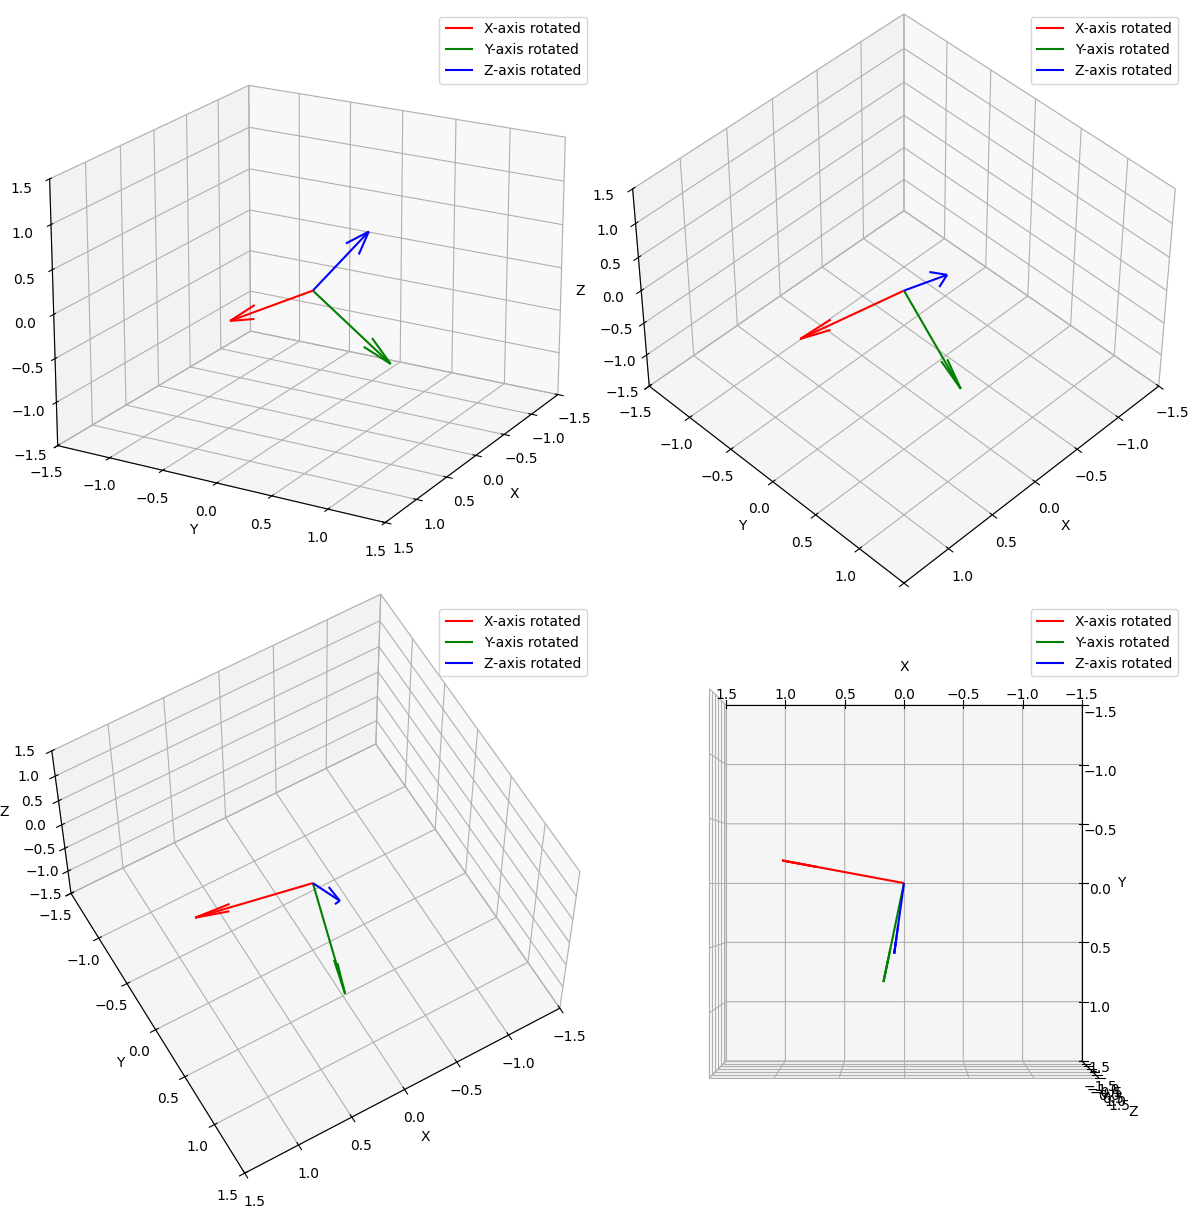

In [ ]:
# plot my rotation


def plot_vector(ax, vec, color, label):
    """
    Plot a 3D vector starting from the origin.
    """
    ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=color, label=label)

# Create the figure and the 3D axis
fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111, projection='3d')

# Original basis vectors
x = np.array([1, 0, 0])
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])

# Define different views
views = [(20, 30), (45, 45), (60, 60), (90, 90)]
axes = [fig.add_subplot(2, 2, i + 1, projection='3d') for i in range(4)]

# Plot original basis vectors
# plot_vector(ax, x, 'r', 'X-axis')
# plot_vector(ax, y, 'g', 'Y-axis')
# plot_vector(ax, z, 'b', 'Z-axis')

# Define the axis of rotation and angle (in radians)
axis = np.array([1, 1, 0])
theta = np.pi / 4  # 45 degrees

R = np.array([[ 0.9827,  0.1686,  0.0768],
         [-0.1827,  0.8118,  0.5547],
         [ 0.0312, -0.5591,  0.8285]])

# axis = np.array([[-104.1493,   -1.5889,   12.7688]])
# R = rotation_matrix(axis, theta)

# Rotate the basis vectors
x_rot = R @ x
y_rot = R @ y
z_rot = R @ z

for ax, (elev, azim) in zip(axes, views):

    # Plot rotated basis vectors
    plot_vector(ax, x_rot, 'r', 'X-axis rotated')
    plot_vector(ax, y_rot, 'g', 'Y-axis rotated')
    plot_vector(ax, z_rot, 'b', 'Z-axis rotated')

    # Setting the plot
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)  # Set the view angle
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_pose = RigidTransform(pose.get_rotation(), -torch.flip(pose.get_translation(), [0,1]))
visualize(drr=drr, pose=test_pose, device=device)

TypeError: visualize() missing 1 required positional argument: 'gt_xray'

In [ ]:
a = torch.tensor([1,2,3])
b = torch.flip(a, [0,1])
b

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

### Preprocessing X-rays

The true X-ray images need to be processed before they look like our DRRs:

- Crop 50 pixels off each edge to remove the effects of the collimator
- Invert the imaging equation to recover the line integral radiograph
- Rescale the image to [0, 1]

From the Beer-Lambert Law, the equation governing fluoroscopy images is
\begin{equation}
    I_f[i, j] = I_0 \exp(-L[i, j]) \,,
\end{equation}
where $L[i, j]$ is the line integral of an X-ray through the volume. 
Inverting this, we recover 
\begin{equation}
    L[i,j] = \log I_0 - \log I_f[i,j] \,,
\end{equation}
where the constant $I_0$ for each image represents the initial energy of each ray. We approximate $I_0 = \max_{i,j} I_f[i,j]$, assuming that this represents a ray that reached the detector plane without first intersecting the volume.

In [ ]:
#| code-fold: true
#| eval: false
specimen = DeepFluoroDataset(
    1,
    filename=filename,
    preprocess=True,  # Set as True to preprocess images
)
processed_xray, _ = specimen[0]

plt.figure(constrained_layout=True)
plt.subplot(121)
plt.title("DRR")
plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")
plt.subplot(122)
plt.title("Processed X-ray")
plt.imshow(processed_xray.squeeze(), cmap="gray")
plt.show()

NameError: name 'DeepFluoroDataset' is not defined

### Changing bone attenuation for DRRs

We can preprocess the CT by segmenting air, soft tissue, and bone before generating DRRs.

- Using `bone_attenuation_multiplier = 1.0` (default) sets the value of air voxels to 0
- Increasing `bone_attenuation_multiplier` weights the density of bones higher than that of soft tissue (i.e., increases contrast in the DRR)

In [ ]:
#| label: bone_attenuation_multiplier = 2.5
#| code-fold: true
#| eval: false
drr = DRR(
    specimen.volume,
    specimen.spacing,
    sdr=specimen.focal_len / 2,
    height=height,
    delx=dx,
    x0=specimen.x0,
    y0=specimen.y0,
    reverse_x_axis=True,
    patch_size=359,
).to(device)

_, pose = specimen[0]
pred_xray = drr(
    rotation=pose.get_rotation().to(device),
    translation=pose.get_translation().to(device),
    parameterization="matrix",
    bone_attenuation_multiplier=2.5,  # Set the bone attenuation multiplier
)

plt.figure(constrained_layout=True)
plt.subplot(121)
plt.title("DRR")
plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")
plt.subplot(122)
plt.title("Processed X-ray")
plt.imshow(processed_xray.squeeze(), cmap="gray")
plt.show()

NameError: name 'specimen' is not defined

Our DRR generated from the ground truth C-arm pose looks remarkably similar to the real X-ray!

### Rotated X-ray test

Some X-ray images in the dataset are rotated 180 degrees. If the X-rays below are in the same orientation, this error in the dataset has been handled properly.

In [ ]:
#| eval: false
true_xray, pose = specimen[34]
pred_xray = drr(
    rotation=pose.get_rotation().to(device),
    translation=pose.get_translation().to(device),
    parameterization="matrix",
)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

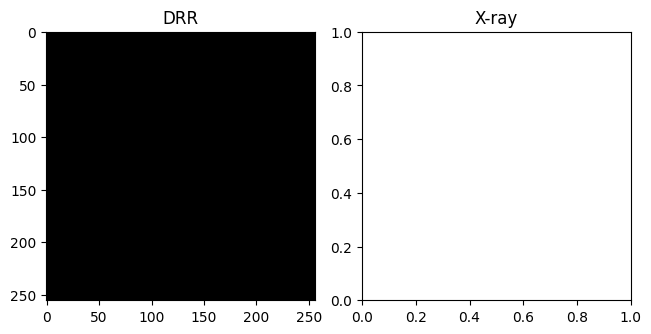

In [ ]:
#| eval: false
#| code-fold: true
plt.figure(constrained_layout=True)
plt.subplot(121)
plt.title("DRR")
plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")
plt.subplot(122)
plt.title("X-ray")
plt.imshow(true_xray.squeeze(), cmap="gray")
plt.show()

## Distribution over camera poses

We sample the three rotational and three translational parameters of $\mathfrak{se}(3)$ from independent normal distributions defined with sufficient variance to capture wide perturbations from the isocenter.

In [ ]:
#| export
from diffpose.calibration import RigidTransform, convert


@beartype
def get_random_offset(batch_size: int, device) -> RigidTransform:
    r1 = torch.distributions.Normal(0, 0.2).sample((batch_size,))
    r2 = torch.distributions.Normal(0, 0.1).sample((batch_size,))
    r3 = torch.distributions.Normal(0, 0.25).sample((batch_size,))
    t1 = torch.distributions.Normal(10, 70).sample((batch_size,))
    t2 = torch.distributions.Normal(250, 90).sample((batch_size,))
    t3 = torch.distributions.Normal(5, 50).sample((batch_size,))
    log_R_vee = torch.stack([r1, r2, r3], dim=1).to(device)
    log_t_vee = torch.stack([t1, t2, t3], dim=1).to(device)
    return convert(
        [log_R_vee, log_t_vee],
        "se3_log_map",
        "se3_exp_map",
    )

## Fiducial markers

The `DeepFluoroDataset` class also contains a method for evaluating the registration error for a predicted pose. Fiducial markers were digitally placed on the preoperative CT. Projecting them with predicted pose parameters can be used to measure their distance from the true fiducials.

In [ ]:
#| eval: false
from diffdrr.utils import convert

# Perturb the ground truth rotations by 0.05 degrees and 2 mm
idx = 0
_, pose = specimen[idx]
euler_angles = (
    convert(pose.get_rotation(), "matrix", "euler_angles", output_convention="ZYX")
    + 0.05
)
R = convert(euler_angles, "euler_angles", "matrix", input_convention="ZYX")
t = pose.get_translation() + 2.0
pred_pose = RigidTransform(R, t)
pred_xray = drr(
    rotation=None,
    translation=None,
    parameterization=None,
    pose=pred_pose.to(device),
)

# Get the fiducials
true_fiducials, pred_fiducials = specimen.get_2d_fiducials(idx, pred_pose)

evaluator = Evaluator(specimen, idx)
registration_error = evaluator(pred_pose).item()
print(f"Registration error = {registration_error} mm")

Registration error = 2.3423616886138916 mm


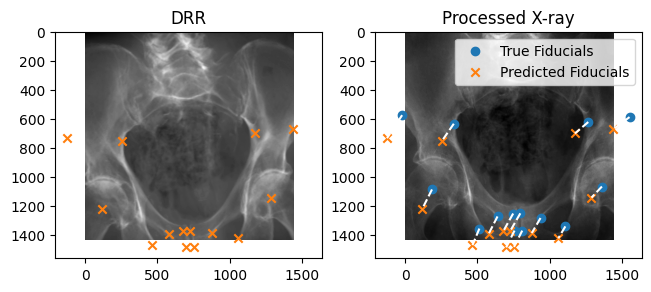

In [ ]:
#| eval: false
#| code-fold: true
plt.figure(constrained_layout=True)
ax = plt.subplot(121)
plt.title("DRR")
plt.imshow(pred_xray.squeeze().cpu().numpy(), cmap="gray")
plt.scatter(
    pred_fiducials[0, ..., 0],
    pred_fiducials[0, ..., 1],
    marker="x",
    c="tab:orange",
)
plt.subplot(122, sharex=ax, sharey=ax)
plt.title("Processed X-ray")
plt.imshow(processed_xray.squeeze(), cmap="gray")
plt.scatter(
    true_fiducials[0, ..., 0],
    true_fiducials[0, ..., 1],
    label="True Fiducials",
)
plt.scatter(
    pred_fiducials[0, ..., 0],
    pred_fiducials[0, ..., 1],
    marker="x",
    c="tab:orange",
    label="Predicted Fiducials",
)
for idx in range(true_fiducials.shape[1]):
    plt.plot(
        [true_fiducials[..., idx, 0].item(), pred_fiducials[..., idx, 0].item()],
        [true_fiducials[..., idx, 1].item(), pred_fiducials[..., idx, 1].item()],
        "w--",
    )
plt.legend()
plt.show()

## Deep learning transforms

We transform X-rays and DRRs before inputting them to a deep learning model by

- Rescaling pixels to [0, 1]
- Resizing the images to a specified size
- Normalizing pixels by the mean and std dev

In [ ]:
#| eval: false
#| code-fold: true
mean, vars = [], []
for idx in range(1, 7):
    specimen = DeepFluoroDataset(idx, filename=filename)
    for img, _ in tqdm(specimen, ncols=50):
        img = (img - img.min()) / (img.max() - img.min())
        mean.append(img.mean())
        vars.append(img.var())

print("Pixel mean :", sum(mean) / len(mean))
print("Pixel std dev :", (sum(vars) / len(vars)).sqrt())

100%|█████████████| 24/24 [00:01<00:00, 12.20it/s]


Pixel mean : tensor(0.3080)
Pixel std dev : tensor(0.1494)


In [ ]:
#| export
from torchvision.transforms import Compose, Lambda, Normalize, Resize


class Transforms:
    def __init__(
        self,
        size: int,  # Dimension to resize image
        eps: float = 1e-6,
    ):
        """Transform X-rays and DRRs before inputting to CNN."""
        self.transforms = Compose(
            [
                Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + eps)),
                Resize((size, size), antialias=True),
                Normalize(mean=0.3080, std=0.1494),
            ]
        )

    def __call__(self, x):
        return self.transforms(x)

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()